<a href="https://colab.research.google.com/github/deep089/Predictive-Maintenance-/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, install required packages
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import io

In [ ]:
def calculate_temperature_recovery(data, temp_range):
    """
    Calculate recovery time for temperature to return to normal range.
    """
    recovery_events = []
    in_anomaly = False
    anomaly_start = None
    anomaly_temp = None

    for i in range(len(data)):
        current_temp = data.iloc[i]['tagvalue']
        current_time = data.iloc[i]['indate']

        is_outside_range = current_temp < temp_range[0] or current_temp > temp_range[1]

        if is_outside_range and not in_anomaly:
            in_anomaly = True
            anomaly_start = current_time
            anomaly_temp = current_temp

        elif not is_outside_range and in_anomaly:
            recovery_time = (current_time - anomaly_start).total_seconds() / 60
            event_type = 'spike' if anomaly_temp > temp_range[1] else 'drop'

            recovery_events.append({
                'start_time': anomaly_start,
                'end_time': current_time,
                'recovery_time_minutes': recovery_time,
                'anomaly_temperature': anomaly_temp,
                'recovery_temperature': current_temp,
                'event_type': event_type,
                'temperature_change': current_temp - anomaly_temp
            })

            in_anomaly = False
            anomaly_start = None
            anomaly_temp = None

    return recovery_events

def prepare_sequences(data, seq_length):
    """
    Prepare sequences for LSTM model with proper alignment
    """
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])

    return np.array(sequences), np.array(targets)

def plot_recovery_periods(critical_data, recovery_events, temp_range):
    """
    Create detailed plots for each recovery period.
    """
    # Create a directory for plots if it doesn't exist
    !mkdir -p recovery_plots

    for i, event in enumerate(recovery_events, 1):
        plt.figure(figsize=(15, 10))

        padding_minutes = 10
        start_time = event['start_time'] - pd.Timedelta(minutes=padding_minutes)
        end_time = event['end_time'] + pd.Timedelta(minutes=padding_minutes)

        period_data = critical_data[
            (critical_data['indate'] >= start_time) &
            (critical_data['indate'] <= end_time)
        ].copy()

        # Temperature plot
        plt.subplot(2, 1, 1)
        plt.plot(period_data['indate'], period_data['tagvalue'],
                'b-', label='Temperature', linewidth=2)
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=temp_range[0], color='orange',
                   linestyle='--', label='Min Normal')
        plt.axhline(y=temp_range[1], color='orange',
                   linestyle='--', label='Max Normal')

        plt.scatter(event['start_time'], event['anomaly_temperature'],
                   color='red', s=100, zorder=5, label='Anomaly Start')
        plt.scatter(event['end_time'], event['recovery_temperature'],
                   color='green', s=100, zorder=5, label='Recovery Point')

        plt.title(f'Recovery Event {i}: {event["event_type"].title()}',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature (°F)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Temperature change rate plot
        plt.subplot(2, 1, 2)
        period_data['temp_change_rate'] = period_data['tagvalue'].diff() / \
            pd.Timedelta(minutes=1).total_seconds() * 60

        plt.plot(period_data['indate'], period_data['temp_change_rate'],
                'purple', label='Change Rate')
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=0, color='gray', linestyle='--')

        plt.title('Temperature Change Rate During Recovery',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature Change Rate (°F/min)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'recovery_plots/recovery_event_{i}.png', dpi=300, bbox_inches='tight')
        plt.close()

def analyze_and_plot_temperature(data, critical_tag='TT-303', temp_range=(495, 530), seq_length=10):
    """
    Analyzes temperature data using LSTM and creates visualizations for anomalies.
    """
    # Process data
    critical_data = data[data['name'] == critical_tag].copy()
    if len(critical_data) == 0:
        print(f"No data found for tag {critical_tag}")
        return None

    # Calculate recovery events
    recovery_events = calculate_temperature_recovery(critical_data, temp_range)

    # Scale data for LSTM
    scaler = MinMaxScaler()
    values = critical_data['tagvalue'].values.reshape(-1, 1)
    scaled_values = scaler.fit_transform(values).flatten()

    # Prepare sequences with proper alignment
    X, y = prepare_sequences(scaled_values, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build and train LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(
        X, y,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Make predictions with proper alignment
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Create a new column for predictions with proper alignment
    critical_data['predicted'] = np.nan
    critical_data.iloc[seq_length:seq_length + len(predictions),
                      critical_data.columns.get_loc('predicted')] = predictions

    # Plot recovery periods
    plot_recovery_periods(critical_data, recovery_events, temp_range)

    # Print analysis
    print("\nTemperature Recovery Analysis:")
    print(f"Total anomaly events: {len(recovery_events)}")

    print("\nDetailed Recovery Events:")
    for i, event in enumerate(recovery_events, 1):
        print(f"\nEvent {i}:")
        print(f"Type: Temperature {event['event_type']}")
        print(f"Start Time: {event['start_time']}")
        print(f"End Time: {event['end_time']}")
        print(f"Recovery Time: {event['recovery_time_minutes']:.2f} minutes")
        print(f"Anomaly Temperature: {event['anomaly_temperature']:.2f}°F")
        print(f"Recovery Temperature: {event['recovery_temperature']:.2f}°F")
        print(f"Temperature Change: {abs(event['temperature_change']):.2f}°F")

    return recovery_events

def read_data_file(filename):
    """
    Read data from either CSV or Excel file.
    """
    try:
        file_extension = os.path.splitext(filename)[1].lower()

        if file_extension == '.csv':
            encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']
            for encoding in encodings:
                try:
                    df = pd.read_csv(filename, encoding=encoding)
                    break
                except UnicodeDecodeError:
                    continue
                except Exception as e:
                    print(f"Error reading CSV with {encoding} encoding: {str(e)}")
                    continue
        elif file_extension in ['.xlsx', '.xls']:
            df = pd.read_excel(filename)
        else:
            # Handle unsupported file types
            print(f"Unsupported file type: {file_extension}")  # Added a print statement for unsupported file types
            return None  # Return None for unsupported file types

        # Check if DataFrame is successfully created
        if df is not None:
            # Convert 'indate' column to datetime if it exists
            if 'indate' in df.columns:
                df['indate'] = pd.to_datetime(df['indate'])
            return df
        else:
            print("Failed to read data file.")
            return None

    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None
def calculate_temperature_recovery(data, temp_range):
    """
    Calculate recovery time for temperature to return to normal range.
    """
    recovery_events = []
    in_anomaly = False
    anomaly_start = None
    anomaly_temp = None

    for i in range(len(data)):
        current_temp = data.iloc[i]['tagvalue']
        current_time = data.iloc[i]['indate']

        is_outside_range = current_temp < temp_range[0] or current_temp > temp_range[1]

        if is_outside_range and not in_anomaly:
            in_anomaly = True
            anomaly_start = current_time
            anomaly_temp = current_temp

        elif not is_outside_range and in_anomaly:
            recovery_time = (current_time - anomaly_start).total_seconds() / 60
            event_type = 'spike' if anomaly_temp > temp_range[1] else 'drop'

            recovery_events.append({
                'start_time': anomaly_start,
                'end_time': current_time,
                'recovery_time_minutes': recovery_time,
                'anomaly_temperature': anomaly_temp,
                'recovery_temperature': current_temp,
                'event_type': event_type,
                'temperature_change': current_temp - anomaly_temp
            })

            in_anomaly = False
            anomaly_start = None
            anomaly_temp = None

    return recovery_events

def prepare_sequences(data, seq_length):
    """
    Prepare sequences for LSTM model with proper alignment
    """
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])

    return np.array(sequences), np.array(targets)

def plot_recovery_periods(critical_data, recovery_events, temp_range):
    """
    Create detailed plots for each recovery period.
    """
    # Create a directory for plots if it doesn't exist
    !mkdir -p recovery_plots

    for i, event in enumerate(recovery_events, 1):
        plt.figure(figsize=(15, 10))

        padding_minutes = 10
        start_time = event['start_time'] - pd.Timedelta(minutes=padding_minutes)
        end_time = event['end_time'] + pd.Timedelta(minutes=padding_minutes)

        period_data = critical_data[
            (critical_data['indate'] >= start_time) &
            (critical_data['indate'] <= end_time)
        ].copy()

        # Temperature plot
        plt.subplot(2, 1, 1)
        plt.plot(period_data['indate'], period_data['tagvalue'],
                'b-', label='Temperature', linewidth=2)
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=temp_range[0], color='orange',
                   linestyle='--', label='Min Normal')
        plt.axhline(y=temp_range[1], color='orange',
                   linestyle='--', label='Max Normal')

        plt.scatter(event['start_time'], event['anomaly_temperature'],
                   color='red', s=100, zorder=5, label='Anomaly Start')
        plt.scatter(event['end_time'], event['recovery_temperature'],
                   color='green', s=100, zorder=5, label='Recovery Point')

        plt.title(f'Recovery Event {i}: {event["event_type"].title()}',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature (°F)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Temperature change rate plot
        plt.subplot(2, 1, 2)
        period_data['temp_change_rate'] = period_data['tagvalue'].diff() / \
            pd.Timedelta(minutes=1).total_seconds() * 60

        plt.plot(period_data['indate'], period_data['temp_change_rate'],
                'purple', label='Change Rate')
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=0, color='gray', linestyle='--')

        plt.title('Temperature Change Rate During Recovery',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature Change Rate (°F/min)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
def calculate_temperature_recovery(data, temp_range):
    """
    Calculate recovery time for temperature to return to normal range.
    """
    recovery_events = []
    in_anomaly = False
    anomaly_start = None
    anomaly_temp = None

    for i in range(len(data)):
        current_temp = data.iloc[i]['tagvalue']
        current_time = data.iloc[i]['indate']

        is_outside_range = current_temp < temp_range[0] or current_temp > temp_range[1]

        if is_outside_range and not in_anomaly:
            in_anomaly = True
            anomaly_start = current_time
            anomaly_temp = current_temp

        elif not is_outside_range and in_anomaly:
            recovery_time = (current_time - anomaly_start).total_seconds() / 60
            event_type = 'spike' if anomaly_temp > temp_range[1] else 'drop'

            recovery_events.append({
                'start_time': anomaly_start,
                'end_time': current_time,
                'recovery_time_minutes': recovery_time,
                'anomaly_temperature': anomaly_temp,
                'recovery_temperature': current_temp,
                'event_type': event_type,
                'temperature_change': current_temp - anomaly_temp
            })

            in_anomaly = False
            anomaly_start = None
            anomaly_temp = None

    return recovery_events

def prepare_sequences(data, seq_length):
    """
    Prepare sequences for LSTM model with proper alignment
    """
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])

    return np.array(sequences), np.array(targets)

def plot_recovery_periods(critical_data, recovery_events, temp_range):
    """
    Create detailed plots for each recovery period.
    """
    # Create a directory for plots if it doesn't exist
    !mkdir -p recovery_plots

    for i, event in enumerate(recovery_events, 1):
        plt.figure(figsize=(15, 10))

        padding_minutes = 10
        start_time = event['start_time'] - pd.Timedelta(minutes=padding_minutes)
        end_time = event['end_time'] + pd.Timedelta(minutes=padding_minutes)

        period_data = critical_data[
            (critical_data['indate'] >= start_time) &
            (critical_data['indate'] <= end_time)
        ].copy()

        # Temperature plot
        plt.subplot(2, 1, 1)
        plt.plot(period_data['indate'], period_data['tagvalue'],
                'b-', label='Temperature', linewidth=2)
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=temp_range[0], color='orange',
                   linestyle='--', label='Min Normal')
        plt.axhline(y=temp_range[1], color='orange',
                   linestyle='--', label='Max Normal')

        plt.scatter(event['start_time'], event['anomaly_temperature'],
                   color='red', s=100, zorder=5, label='Anomaly Start')
        plt.scatter(event['end_time'], event['recovery_temperature'],
                   color='green', s=100, zorder=5, label='Recovery Point')

        plt.title(f'Recovery Event {i}: {event["event_type"].title()}',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature (°F)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Temperature change rate plot
        plt.subplot(2, 1, 2)
        period_data['temp_change_rate'] = period_data['tagvalue'].diff() / \
            pd.Timedelta(minutes=1).total_seconds() * 60

        plt.plot(period_data['indate'], period_data['temp_change_rate'],
                'purple', label='Change Rate')
        plt.axvspan(event['start_time'], event['end_time'],
                   alpha=0.2, color='yellow', label='Recovery Period')
        plt.axhline(y=0, color='gray', linestyle='--')

        plt.title('Temperature Change Rate During Recovery',
                 fontsize=14, pad=20)
        plt.xlabel('Time')
        plt.ylabel('Temperature Change Rate (°F/min)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'recovery_plots/recovery_event_{i}.png', dpi=300, bbox_inches='tight')
        plt.close()

# Main execution block
print("Please upload your Excel or CSV file...")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    df = read_data_file(filename)

    if df is not None:
        recovery_events = analyze_and_plot_temperature(df)
        print("\nAnalysis complete! The plots have been saved in the 'recovery_plots' directory.")
    else:
        print("Failed to read the data file. Please check the file format and try again.")
else:
    print("No file was uploaded. Please run the cell again and upload a file.")

Please upload your Excel or CSV file...


No file was uploaded. Please run the cell again and upload a file.


In [ ]:
# Method 1: Upload multiple Excel files directly to Colab session
from google.colab import files
import pandas as pd
import io

def upload_multiple_excel_files():
    # Upload multiple files from your computer
    uploaded = files.upload()

    # Dictionary to store DataFrames
    dfs = {}

    # Process each uploaded file
    for filename, content in uploaded.items():
        try:
            # Check if it's an Excel file or Google Sheets export
            if filename.endswith(('.xlsx', '.xls', '.xlsm')):
                # Read Excel file
                df = pd.read_excel(io.BytesIO(content))
            elif filename.endswith('.csv'):
                # Read CSV (common Google Sheets export format)
                df = pd.read_csv(io.BytesIO(content))
            else:
                print(f"Unsupported file format: {filename}")
                continue

            # Store DataFrame in dictionary
            dfs[filename] = df

            # Display preview
            print(f"\nPreview of {filename}:")
            display(df.head())

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

    return dfs

# Execute the function to upload files
file_dataframes = upload_multiple_excel_files()

# Method 2: Load multiple Excel/Google Sheets files from Google Drive
from google.colab import drive
import pandas as pd
import os
import glob

def load_sheets_from_drive(directory_path=None):
    # Mount Google Drive if not already mounted
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except:
        print("Google Drive already mounted")

    if directory_path is None:
        # Default path - update this to your folder with spreadsheets
        directory_path = '/content/drive/My Drive/spreadsheets'

    # Dictionary to store DataFrames
    dfs = {}

    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Directory not found: {directory_path}")
        return dfs

    # Find all Excel and CSV files (exported Google Sheets) in the directory
    excel_files = glob.glob(os.path.join(directory_path, "*.xlsx"))
    excel_files += glob.glob(os.path.join(directory_path, "*.xls"))
    excel_files += glob.glob(os.path.join(directory_path, "*.xlsm"))
    csv_files = glob.glob(os.path.join(directory_path, "*.csv"))

    # Process Excel files
    for file_path in excel_files:
        try:
            filename = os.path.basename(file_path)
            df = pd.read_excel(file_path)
            dfs[filename] = df
            print(f"\nPreview of {filename}:")
            display(df.head())
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")

    # Process CSV files (exported Google Sheets)
    for file_path in csv_files:
        try:
            filename = os.path.basename(file_path)
            df = pd.read_csv(file_path)
            dfs[filename] = df
            print(f"\nPreview of {filename}:")
            display(df.head())
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")

    print(f"Loaded {len(dfs)} files successfully")
    return dfs


Saving 4Day_FeedSampleData.csv to 4Day_FeedSampleData (2).csv

Preview of 4Day_FeedSampleData (2).csv:


,id,name,type,unit,category,description,tagvalue,indate,logdate,snapshot
0,410495,P1-Pump,Speed,hz,Feed,Progressive C. Pump Feed,0.00,2025-01-15 04:38:01.157967+00,2025-01-14 16:38:32+00,False
1,410496,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,0.00,2025-01-15 04:38:01.238513+00,2025-01-14 16:38:32+00,False
2,410497,M1-Mixer,Speed,hz,Feed,T1 Mixer,0.00,2025-01-15 04:38:01.239463+00,2025-01-14 16:38:32+00,False
3,410498,PIT-100,Pressure,psi,Feed,P2 Recirc Pressure,2.55,2025-01-15 04:38:01.471898+00,2025-01-14 16:38:32+00,False
4,410502,LIT-100,Level,%,Feed,T1 Level,55.40,2025-01-15 04:38:01.585855+00,2025-01-14 16:38:32+00,False


Found 6847 rows of P2-Pump data
Using 'indate' as the date column and 'tagvalue' as the value column


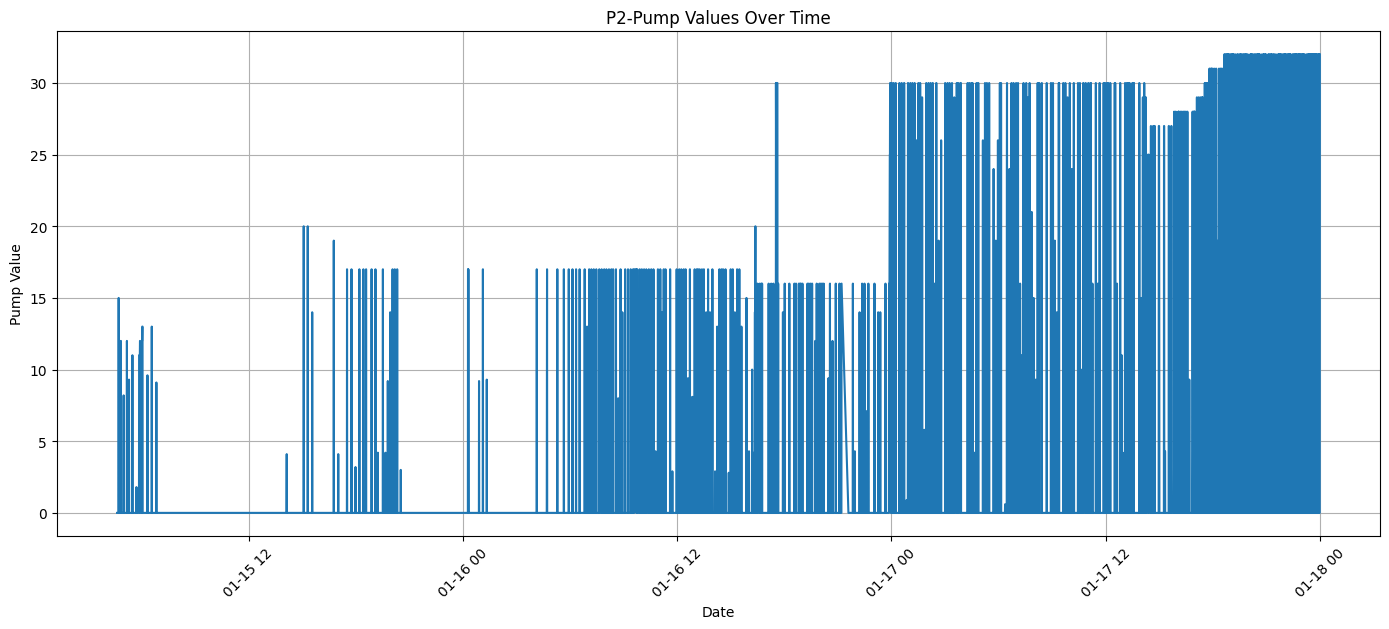

<ipython-input-6-c174567f7fc4>:208: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p2_pump_hourly = p2_pump_data.set_index(date_column)[value_column].resample('1H').mean().fillna(method='ffill')
<ipython-input-6-c174567f7fc4>:208: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  p2_pump_hourly = p2_pump_data.set_index(date_column)[value_column].resample('1H').mean().fillna(method='ffill')


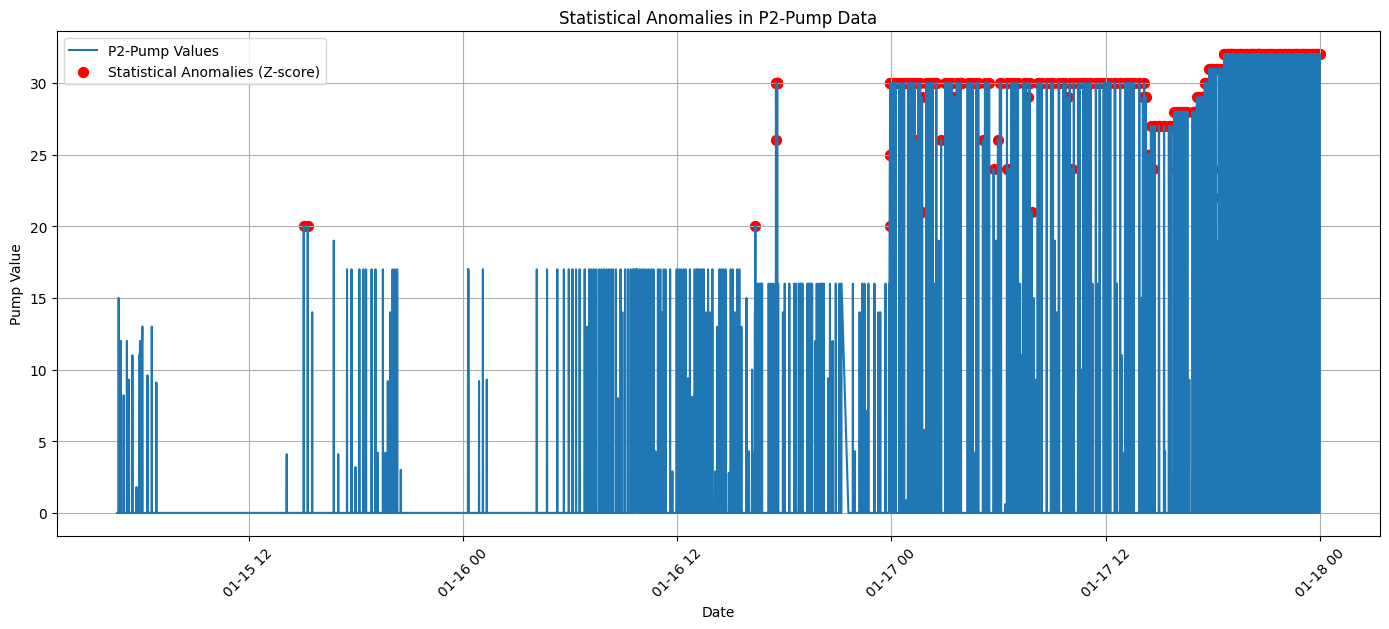

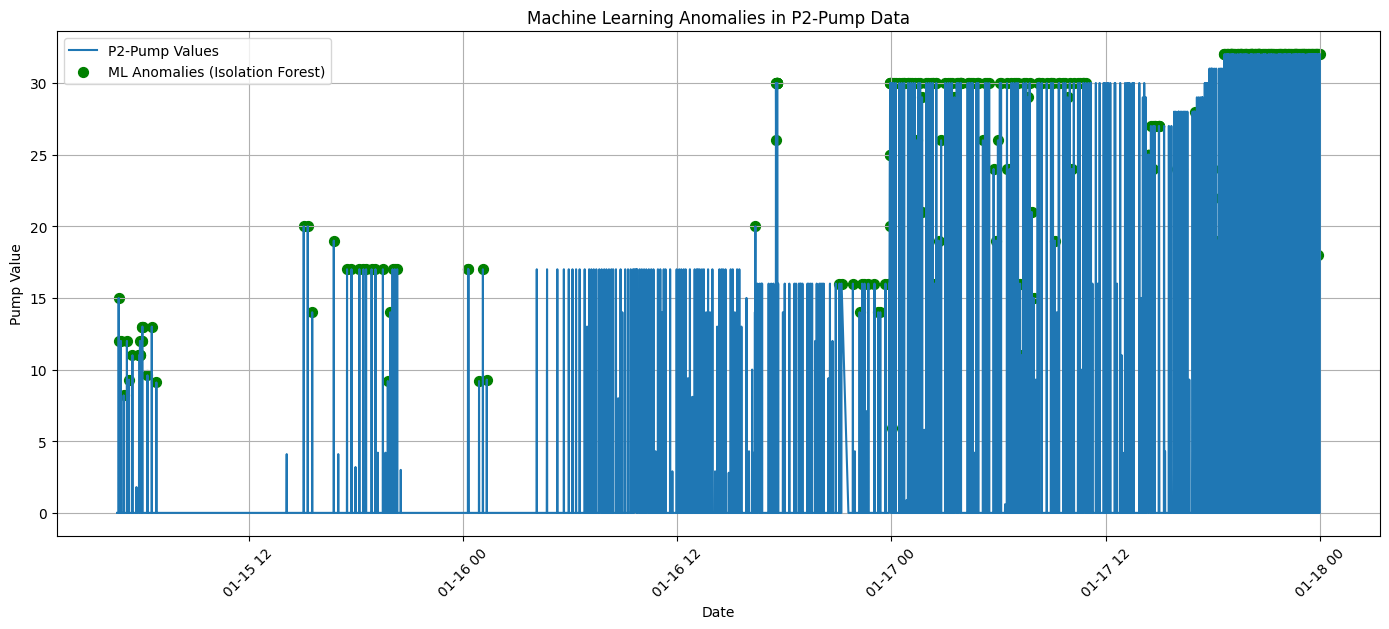

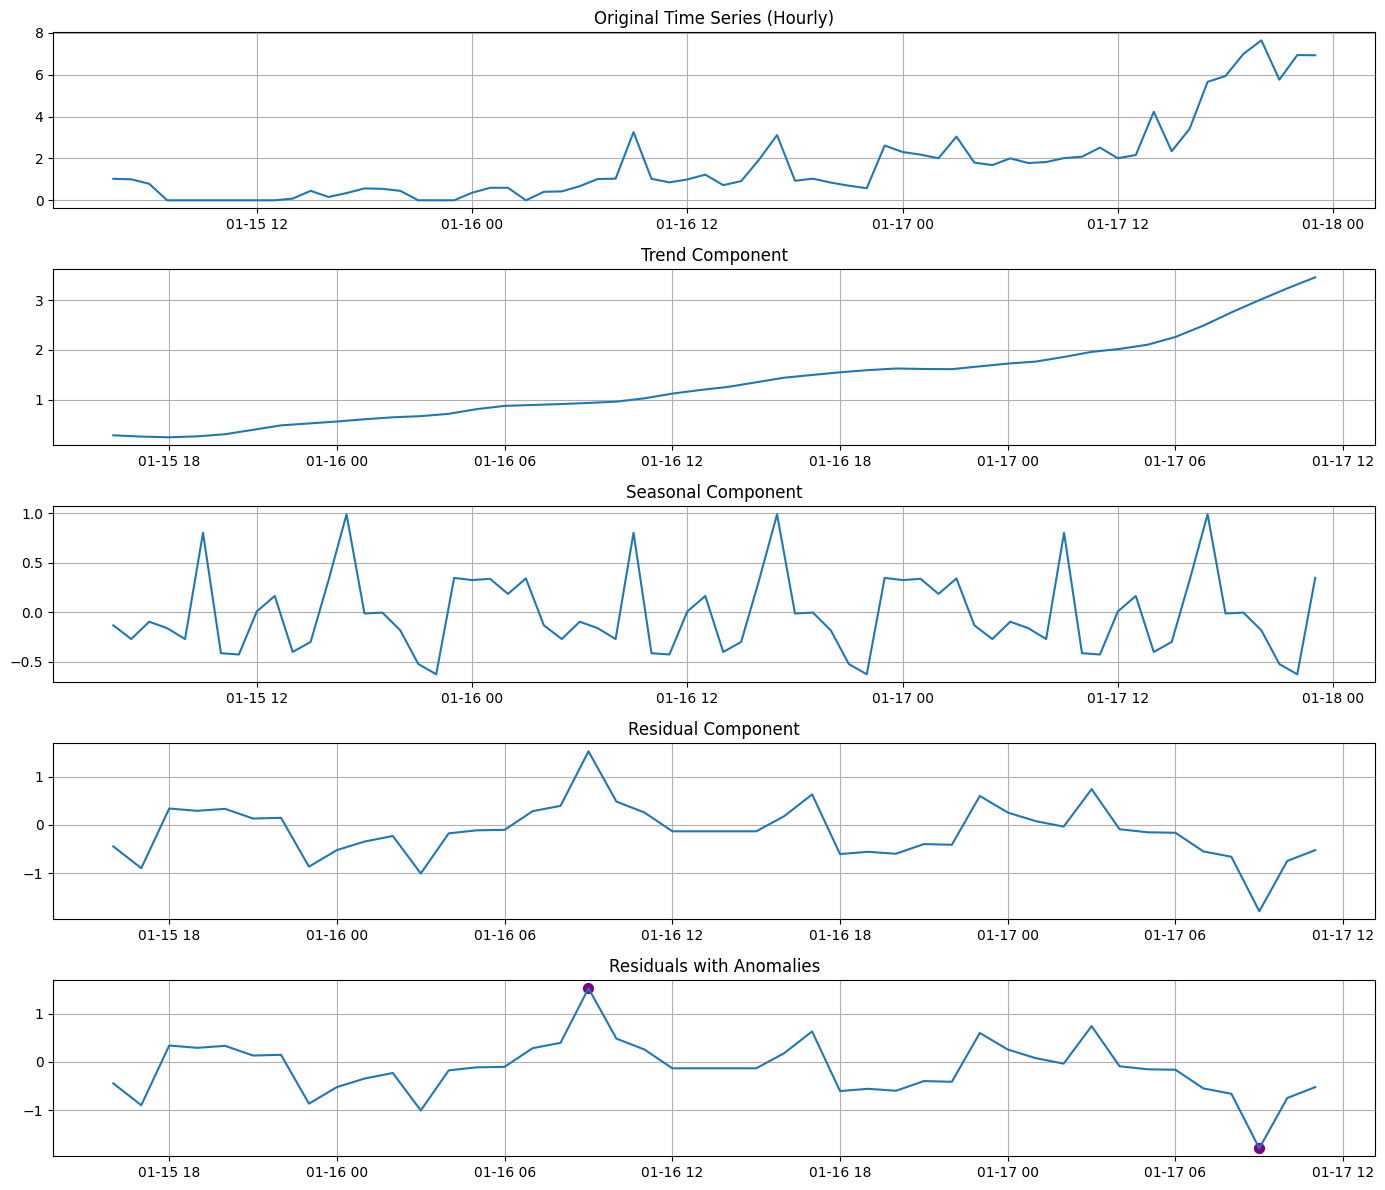

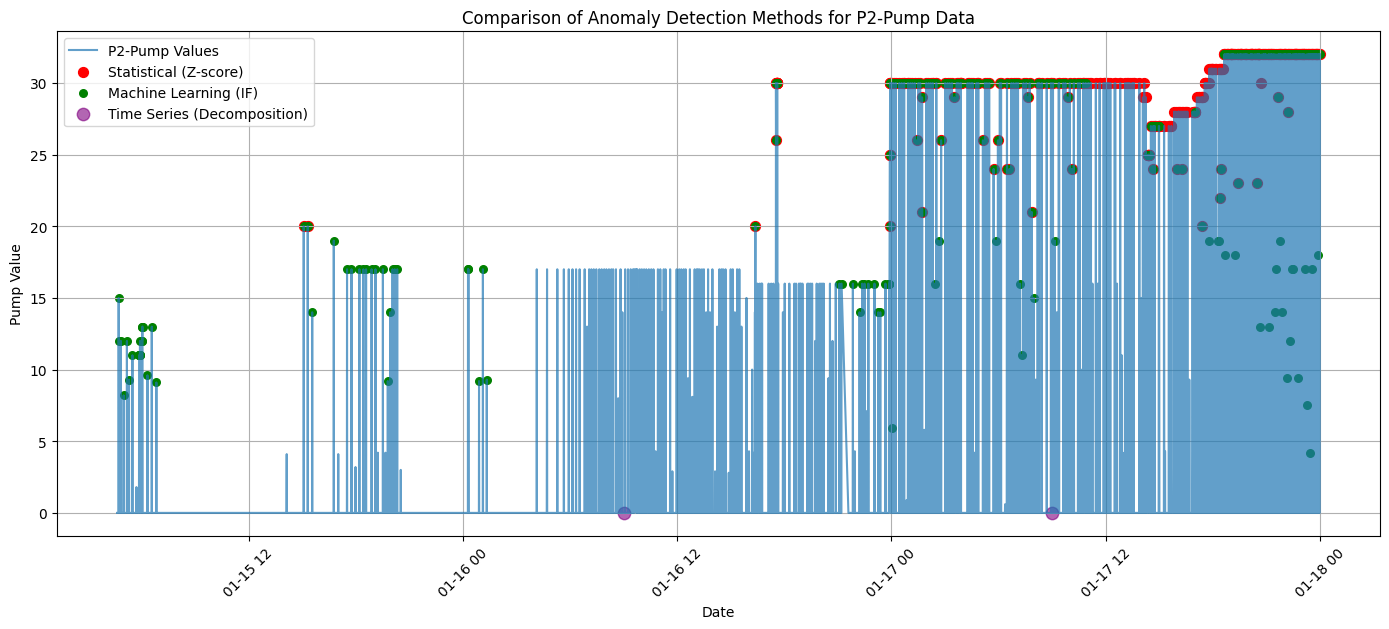

Total data points: 6847
Statistical anomalies detected: 332
Machine learning anomalies detected: 339
Time series anomalies detected: 2

Common anomalies between Statistical and ML methods: 253
Common anomalies between Statistical and Time Series methods: 0
Common anomalies between ML and Time Series methods: 0
Common anomalies across all three methods: 0

Top 10 most reliable anomalies:


,indate,tagvalue,detection_count
2872,2025-01-15 15:05:19.006775+00:00,20.0,2
3088,2025-01-15 15:18:48.926897+00:00,20.0,2
24822,2025-01-16 16:23:02.948358+00:00,20.0,2
25926,2025-01-16 17:32:03.727363+00:00,30.0,2
25934,2025-01-16 17:32:33.728565+00:00,26.0,2
25950,2025-01-16 17:33:33.740035+00:00,30.0,2
25958,2025-01-16 17:34:03.958809+00:00,30.0,2
25966,2025-01-16 17:34:33.748471+00:00,30.0,2
25974,2025-01-16 17:35:03.748806+00:00,30.0,2
25982,2025-01-16 17:35:33.757701+00:00,30.0,2


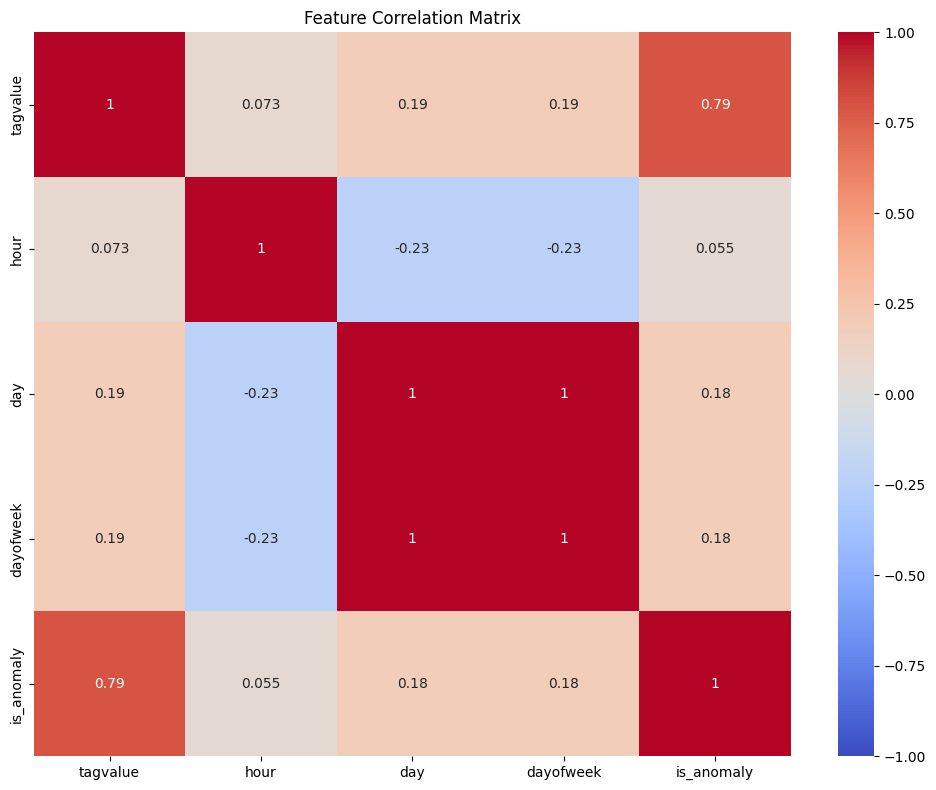


================ ANOMALY DETECTION SUMMARY ================
Analysis period: 2025-01-15 04:38:01.238513+00:00 to 2025-01-17 23:59:46.856632+00:00
Total data points analyzed: 6847
Total anomalies detected: 253
Anomaly percentage: 3.70%

Hour distribution of anomalies:
Hour 0: 9 anomalies
Hour 1: 9 anomalies
Hour 2: 7 anomalies
Hour 3: 12 anomalies
Hour 4: 7 anomalies
Hour 5: 6 anomalies
Hour 6: 8 anomalies
Hour 7: 6 anomalies
Hour 8: 7 anomalies
Hour 9: 7 anomalies
Hour 10: 8 anomalies
Hour 14: 15 anomalies
Hour 15: 3 anomalies
Hour 16: 2 anomalies
Hour 17: 12 anomalies
Hour 18: 10 anomalies
Hour 19: 25 anomalies
Hour 20: 27 anomalies
Hour 21: 18 anomalies
Hour 22: 24 anomalies
Hour 23: 31 anomalies

Day of month distribution of anomalies:
Day 15: 2 anomalies
Day 16: 18 anomalies
Day 17: 233 anomalies

Day of week distribution of anomalies:
Wednesday: 2 anomalies
Thursday: 18 anomalies
Friday: 233 anomalies


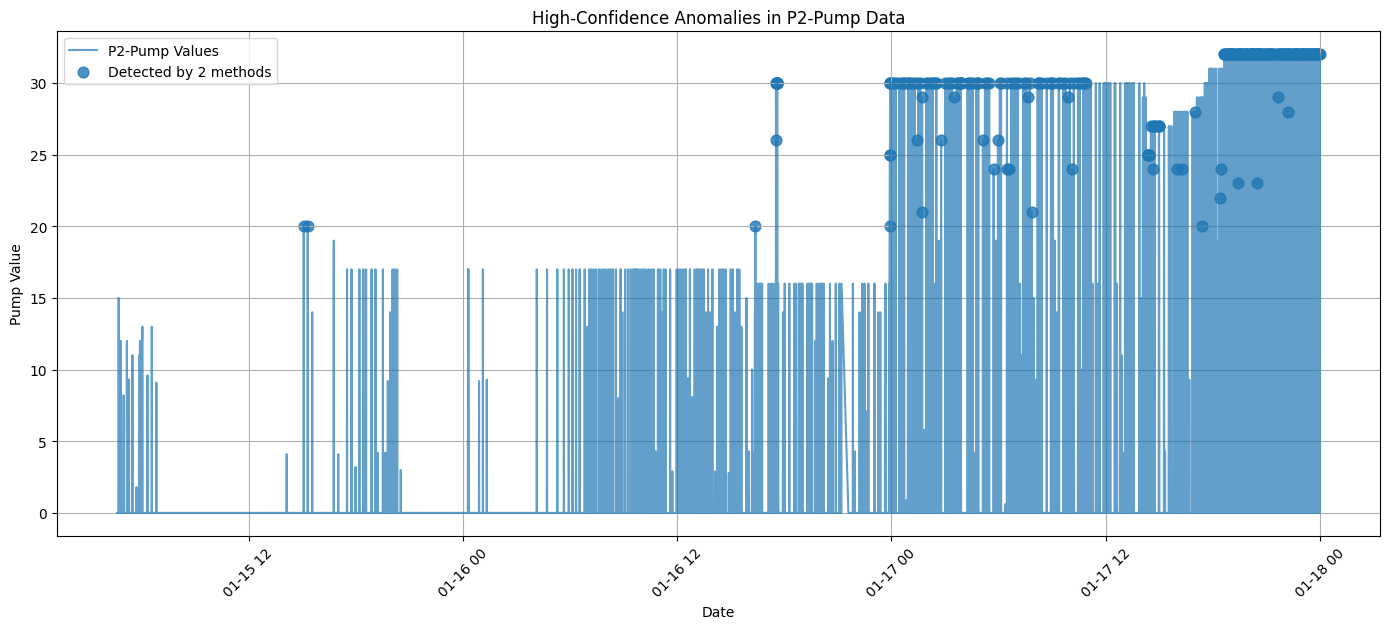


Detailed anomaly information:


,id,name,type,unit,category,description,tagvalue,indate,logdate,snapshot,hour,day,dayofweek,detection_count
2872,428085,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,20.0,2025-01-15 15:05:19.006775+00:00,2025-01-15 03:05:52+00,False,15,15,2,2
3088,429408,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,20.0,2025-01-15 15:18:48.926897+00:00,2025-01-15 03:19:22+00,False,15,15,2,2
24822,601448,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,20.0,2025-01-16 16:23:02.948358+00:00,2025-01-16 04:23:35+00,False,16,16,3,2
25926,608210,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,30.0,2025-01-16 17:32:03.727363+00:00,2025-01-16 05:32:35+00,False,17,16,3,2
25934,608259,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,26.0,2025-01-16 17:32:33.728565+00:00,2025-01-16 05:33:05+00,False,17,16,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54579,783700,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,32.0,2025-01-17 23:49:16.766136+00:00,2025-01-17 11:49:48+00,False,23,17,4,2
54587,783749,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,32.0,2025-01-17 23:49:46.768072+00:00,2025-01-17 11:50:18+00,False,23,17,4,2
54643,784092,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,32.0,2025-01-17 23:53:16.800097+00:00,2025-01-17 11:53:48+00,False,23,17,4,2
54691,784386,P2-Pump,Speed,hz,Feed,High Pressure Feed Pump,32.0,2025-01-17 23:56:16.819205+00:00,2025-01-17 11:56:48+00,False,23,17,4,2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Assuming you've already uploaded your files using the previous code
# Let's use the file_dataframes dictionary we created in the upload code
# If you haven't run that code yet, uncomment and run this section:


from google.colab import files
import pandas as pd
import io

# Upload multiple files from your computer
uploaded = files.upload()

# Dictionary to store DataFrames
file_dataframes = {}

# Process each uploaded file
for filename, content in uploaded.items():
    try:
        # Check if it's an Excel file or Google Sheets export
        if filename.endswith(('.xlsx', '.xls', '.xlsm')):
            # Read Excel file
            df = pd.read_excel(io.BytesIO(content))
        elif filename.endswith('.csv'):
            # Read CSV (common Google Sheets export format)
            df = pd.read_csv(io.BytesIO(content))
        else:
            print(f"Unsupported file format: {filename}")
            continue

        # Store DataFrame in dictionary
        file_dataframes[filename] = df

        # Display preview
        print(f"\nPreview of {filename}:")
        display(df.head())

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")


# Extract the Feed data from the uploaded files
# Assuming '4Day_FeedSampleData.xlsx' is the key in file_dataframes
feed_data = file_dataframes.get('4Day_FeedSampleData.csv')

# If the key is different, you might need to find it
if feed_data is None:
    for key in file_dataframes.keys():
        if 'Feed' in key:
            feed_data = file_dataframes[key]
            break

# Check if we found the feed data
if feed_data is None:
    raise ValueError("Could not find the Feed Sample Data in the uploaded files")

# Filter for P2-PumpSpeed data
# First, let's check if the 'name' column exists and has the right format
if 'name' not in feed_data.columns:
    # Try to find the column that contains pump information
    pump_column = None
    for col in feed_data.columns:
        if any('pump' in str(val).lower() for val in feed_data[col].unique()):
            pump_column = col
            break

    if pump_column is None:
        raise ValueError("Could not find a column containing pump information")

    print(f"Using '{pump_column}' as the name column")
    name_column = pump_column
else:
    name_column = 'name'

# Filter for P2-Pump data
p2_pump_data = feed_data[feed_data[name_column].str.contains('P2-Pump', case=False, na=False)].copy()

# Check if we found P2-Pump data
if len(p2_pump_data) == 0:
    print("No P2-Pump data found. Here are the unique values in the name column:")
    print(feed_data[name_column].unique())
    # As a fallback, we'll try to find any pump-related data
    p2_pump_data = feed_data[feed_data[name_column].str.contains('Pump', case=False, na=False)].copy()

    if len(p2_pump_data) == 0:
        raise ValueError("Could not find any pump data in the Feed Sample Data")
    else:
        print(f"Found {len(p2_pump_data)} rows of generic pump data")
else:
    print(f"Found {len(p2_pump_data)} rows of P2-Pump data")

# Ensure we have the correct date column
date_column = None
for col in p2_pump_data.columns:
    if col.lower() == 'indate':
        date_column = col
        break
    elif 'date' in col.lower() or 'time' in col.lower():
        date_column = col
        break

if date_column is None:
    raise ValueError("Could not find a date/time column in the data")

# Ensure we have the value column
value_column = None
for col in p2_pump_data.columns:
    if col.lower() == 'value':
        value_column = col
        break
    elif any(x in col.lower() for x in ['speed', 'rate', 'flow', 'hz']):
        value_column = col
        break

if value_column is None:
    # Try to infer it by looking for numeric columns
    numeric_cols = p2_pump_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        # Exclude any columns that look like IDs
        value_cols = [col for col in numeric_cols if not ('id' in col.lower() or 'index' in col.lower())]
        if len(value_cols) > 0:
            value_column = value_cols[0]
        else:
            value_column = numeric_cols[0]
    else:
        raise ValueError("Could not find a value column in the data")

print(f"Using '{date_column}' as the date column and '{value_column}' as the value column")

# Convert date column to datetime if it's not already
try:
    p2_pump_data[date_column] = pd.to_datetime(p2_pump_data[date_column])
except:
    print(f"Warning: Could not convert {date_column} to datetime. Using as-is.")

# Sort by date
p2_pump_data = p2_pump_data.sort_values(date_column)

# Create time-based features if we have a proper datetime
try:
    p2_pump_data['hour'] = p2_pump_data[date_column].dt.hour
    p2_pump_data['day'] = p2_pump_data[date_column].dt.day
    p2_pump_data['dayofweek'] = p2_pump_data[date_column].dt.dayofweek
    time_features_available = True
except:
    print("Warning: Could not extract time features from date column")
    time_features_available = False

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(p2_pump_data[date_column], p2_pump_data[value_column])
plt.title('P2-Pump Values Over Time')
plt.xlabel('Date')
plt.ylabel('Pump Value')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Check if we have enough data for meaningful analysis
if len(p2_pump_data) < 10:
    print(f"Warning: Only {len(p2_pump_data)} data points available. Analysis may not be reliable.")

# 1. Statistical Analysis - Z-score method
p2_pump_data['zscore'] = stats.zscore(p2_pump_data[value_column])
statistical_anomalies = p2_pump_data[abs(p2_pump_data['zscore']) > 2.5].copy()

# 2. Machine Learning - Isolation Forest
if time_features_available:
    features = [value_column, 'hour', 'dayofweek']
else:
    features = [value_column]

# Handle any non-numeric data in features
for feat in features:
    if p2_pump_data[feat].dtype == 'object':
        try:
            p2_pump_data[feat] = pd.to_numeric(p2_pump_data[feat])
        except:
            print(f"Warning: Could not convert {feat} to numeric. Removing from features.")
            features.remove(feat)

if len(features) == 0:
    print("No numeric features available for Isolation Forest. Skipping ML anomaly detection.")
    ml_anomalies = pd.DataFrame()
else:
    scaler = StandardScaler()
    p2_pump_scaled = scaler.fit_transform(p2_pump_data[features])

    # Train isolation forest
    clf = IsolationForest(contamination=0.05, random_state=42)  # Using 5% contamination for sparser data
    p2_pump_data['anomaly_score'] = clf.fit_predict(p2_pump_scaled)
    ml_anomalies = p2_pump_data[p2_pump_data['anomaly_score'] == -1].copy()

# 3. Time Series Decomposition
# Need at least 2 periods for decomposition (48 data points for hourly data)
if len(p2_pump_data) >= 48 and time_features_available:
    try:
        # Resample to hourly for decomposition (smoother analysis)
        p2_pump_hourly = p2_pump_data.set_index(date_column)[value_column].resample('1H').mean().fillna(method='ffill')

        # If we have at least 2 days of data
        if len(p2_pump_hourly) >= 48:
            # Decompose the time series
            decomposition = seasonal_decompose(p2_pump_hourly, model='additive', period=24)  # 24 hours as period

            # Extract residuals and detect anomalies
            residuals = decomposition.resid
            residuals.dropna(inplace=True)
            residuals_mean = residuals.mean()
            residuals_std = residuals.std()
            ts_anomalies = residuals[abs(residuals - residuals_mean) > 2.5 * residuals_std]

            # Flag for time series decomposition availability
            ts_decomposition_available = True
        else:
            print("Not enough data for meaningful time series decomposition (need at least 48 hourly points)")
            ts_anomalies = pd.Series()
            ts_decomposition_available = False
    except Exception as e:
        print(f"Time series decomposition failed: {str(e)}")
        ts_anomalies = pd.Series()
        ts_decomposition_available = False
else:
    print("Not enough data for time series decomposition")
    ts_anomalies = pd.Series()
    ts_decomposition_available = False

# Visualize the statistical anomalies
plt.figure(figsize=(14, 6))
plt.plot(p2_pump_data[date_column], p2_pump_data[value_column], label='P2-Pump Values')
plt.scatter(statistical_anomalies[date_column], statistical_anomalies[value_column],
            color='red', s=50, label='Statistical Anomalies (Z-score)')
plt.title('Statistical Anomalies in P2-Pump Data')
plt.xlabel('Date')
plt.ylabel('Pump Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Visualize the machine learning anomalies if available
if len(ml_anomalies) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(p2_pump_data[date_column], p2_pump_data[value_column], label='P2-Pump Values')
    plt.scatter(ml_anomalies[date_column], ml_anomalies[value_column],
                color='green', s=50, label='ML Anomalies (Isolation Forest)')
    plt.title('Machine Learning Anomalies in P2-Pump Data')
    plt.xlabel('Date')
    plt.ylabel('Pump Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Visualize the time series decomposition if available
if ts_decomposition_available:
    plt.figure(figsize=(14, 12))

    plt.subplot(5, 1, 1)
    plt.plot(p2_pump_hourly)
    plt.title('Original Time Series (Hourly)')
    plt.grid(True)

    plt.subplot(5, 1, 2)
    plt.plot(decomposition.trend)
    plt.title('Trend Component')
    plt.grid(True)

    plt.subplot(5, 1, 3)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal Component')
    plt.grid(True)

    plt.subplot(5, 1, 4)
    plt.plot(decomposition.resid)
    plt.title('Residual Component')
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(residuals)
    plt.scatter(ts_anomalies.index, ts_anomalies.values, color='purple', s=50)
    plt.title('Residuals with Anomalies')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Compare different anomaly detection methods
plt.figure(figsize=(14, 6))
plt.plot(p2_pump_data[date_column], p2_pump_data[value_column], alpha=0.7, label='P2-Pump Values')
plt.scatter(statistical_anomalies[date_column], statistical_anomalies[value_column],
            color='red', s=50, label='Statistical (Z-score)')

if len(ml_anomalies) > 0:
    plt.scatter(ml_anomalies[date_column], ml_anomalies[value_column],
                color='green', s=30, label='Machine Learning (IF)')

# Add time series anomalies if available
if ts_decomposition_available and len(ts_anomalies) > 0:
    ts_anomaly_dates = ts_anomalies.index
    ts_anomaly_values = []
    for date in ts_anomaly_dates:
        # Find the closest value in the original dataset
        closest_date_idx = (p2_pump_data[date_column] - date).abs().idxmin()
        ts_anomaly_values.append(p2_pump_data.loc[closest_date_idx, value_column])

    plt.scatter(ts_anomaly_dates, ts_anomaly_values,
                color='purple', s=80, alpha=0.6, label='Time Series (Decomposition)')

plt.title('Comparison of Anomaly Detection Methods for P2-Pump Data')
plt.xlabel('Date')
plt.ylabel('Pump Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Create a summary of anomalies
print("Total data points:", len(p2_pump_data))
print("Statistical anomalies detected:", len(statistical_anomalies))
if len(ml_anomalies) > 0:
    print("Machine learning anomalies detected:", len(ml_anomalies))
if ts_decomposition_available:
    print("Time series anomalies detected:", len(ts_anomalies))

# Find common anomalies across methods (more reliable detections)
statistical_anomaly_dates = set(statistical_anomalies[date_column])
ml_anomaly_dates = set() if len(ml_anomalies) == 0 else set(ml_anomalies[date_column])

# Convert time series index to datetime for comparison
ts_anomaly_dates_set = set()
if ts_decomposition_available and len(ts_anomalies) > 0:
    for date in ts_anomaly_dates:
        # Find the closest date in the original dataset
        closest_date_idx = (p2_pump_data[date_column] - date).abs().idxmin()
        ts_anomaly_dates_set.add(p2_pump_data.loc[closest_date_idx, date_column])

# Find intersections
if len(ml_anomaly_dates) > 0:
    stat_ml_common = statistical_anomaly_dates.intersection(ml_anomaly_dates)
    print("\nCommon anomalies between Statistical and ML methods:", len(stat_ml_common))
else:
    stat_ml_common = set()

if len(ts_anomaly_dates_set) > 0:
    stat_ts_common = statistical_anomaly_dates.intersection(ts_anomaly_dates_set)
    print("Common anomalies between Statistical and Time Series methods:", len(stat_ts_common))
else:
    stat_ts_common = set()

if len(ml_anomaly_dates) > 0 and len(ts_anomaly_dates_set) > 0:
    ml_ts_common = ml_anomaly_dates.intersection(ts_anomaly_dates_set)
    print("Common anomalies between ML and Time Series methods:", len(ml_ts_common))
else:
    ml_ts_common = set()

all_common = set()
if len(ml_anomaly_dates) > 0 and len(ts_anomaly_dates_set) > 0:
    all_common = statistical_anomaly_dates.intersection(ml_anomaly_dates).intersection(ts_anomaly_dates_set)
    print("Common anomalies across all three methods:", len(all_common))

# Create a dataframe with only the high-confidence anomalies (detected by at least 2 methods)
high_confidence_dates = list(stat_ml_common.union(stat_ts_common).union(ml_ts_common))
high_confidence_anomalies = p2_pump_data[p2_pump_data[date_column].isin(high_confidence_dates)].copy()

# If we don't have any high-confidence anomalies, use statistical ones
if len(high_confidence_anomalies) == 0:
    print("\nNo high-confidence anomalies detected. Using statistical anomalies.")
    high_confidence_anomalies = statistical_anomalies.copy()
    high_confidence_anomalies['detection_count'] = 1
else:
    # Add a column indicating how many methods detected this anomaly
    high_confidence_anomalies['detection_count'] = 0
    for idx, row in high_confidence_anomalies.iterrows():
        count = 0
        if row[date_column] in statistical_anomaly_dates:
            count += 1
        if row[date_column] in ml_anomaly_dates:
            count += 1
        if row[date_column] in ts_anomaly_dates_set:
            count += 1
        high_confidence_anomalies.loc[idx, 'detection_count'] = count

# Sort by detection count (most reliable first)
high_confidence_anomalies = high_confidence_anomalies.sort_values(by=['detection_count', date_column], ascending=[False, True])

# Display the top anomalies (or all if less than 10)
num_to_display = min(10, len(high_confidence_anomalies))
print(f"\nTop {num_to_display} most reliable anomalies:")
top_anomalies = high_confidence_anomalies.head(num_to_display)
display(top_anomalies[[date_column, value_column, 'detection_count']])

# Feature correlation analysis if we have time features
if time_features_available:
    corr_features = [value_column, 'hour', 'day', 'dayofweek']
    corr_data = p2_pump_data[corr_features].copy()
    corr_data['is_anomaly'] = p2_pump_data[date_column].isin(high_confidence_dates).astype(int)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Summary report
print("\n================ ANOMALY DETECTION SUMMARY ================")
print(f"Analysis period: {p2_pump_data[date_column].min()} to {p2_pump_data[date_column].max()}")
print(f"Total data points analyzed: {len(p2_pump_data)}")
print(f"Total anomalies detected: {len(high_confidence_anomalies)}")
print(f"Anomaly percentage: {len(high_confidence_anomalies)/len(p2_pump_data)*100:.2f}%")

# Analyze patterns in anomalies if we have time features
if time_features_available:
    hour_distribution = high_confidence_anomalies['hour'].value_counts().sort_index()
    day_distribution = high_confidence_anomalies['day'].value_counts().sort_index()
    dayofweek_distribution = high_confidence_anomalies['dayofweek'].value_counts().sort_index()

    print("\nHour distribution of anomalies:")
    for hour, count in hour_distribution.items():
        print(f"Hour {hour}: {count} anomalies")

    print("\nDay of month distribution of anomalies:")
    for day, count in day_distribution.items():
        print(f"Day {day}: {count} anomalies")

    print("\nDay of week distribution of anomalies:")
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for dow, count in dayofweek_distribution.items():
        print(f"{days[dow]}: {count} anomalies")

# Final visualization showing high-confidence anomalies
plt.figure(figsize=(14, 6))
plt.plot(p2_pump_data[date_column], p2_pump_data[value_column], alpha=0.7, label='P2-Pump Values')

# Color code by number of methods that detected the anomaly
if 'detection_count' in high_confidence_anomalies.columns:
    for count in sorted(high_confidence_anomalies['detection_count'].unique(), reverse=True):
        subset = high_confidence_anomalies[high_confidence_anomalies['detection_count'] == count]
        if len(subset) > 0:
            plt.scatter(subset[date_column], subset[value_column],
                        s=80-20*(3-count), alpha=0.8,
                        label=f'Detected by {count} method{"s" if count > 1 else ""}')
else:
    plt.scatter(high_confidence_anomalies[date_column], high_confidence_anomalies[value_column],
                s=80, alpha=0.8, label='Anomalies')

plt.title('High-Confidence Anomalies in P2-Pump Data')
plt.xlabel('Date')
plt.ylabel('Pump Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Print the detailed anomaly information
print("\nDetailed anomaly information:")
columns_to_display = [col for col in high_confidence_anomalies.columns
                     if col not in ['zscore', 'anomaly_score']]
display(high_confidence_anomalies[columns_to_display])

Please upload your data files (.csv, .xlsx, .xls, or .xlsm)


Saving 4Day_SeparatorSampleData.csv to 4Day_SeparatorSampleData (3).csv
Processing file: 4Day_SeparatorSampleData (3).csv
Successfully loaded 4Day_SeparatorSampleData (3).csv with 47917 rows and 10 columns

ANALYZING PIT-104
Found 6847 rows of PIT-104 data


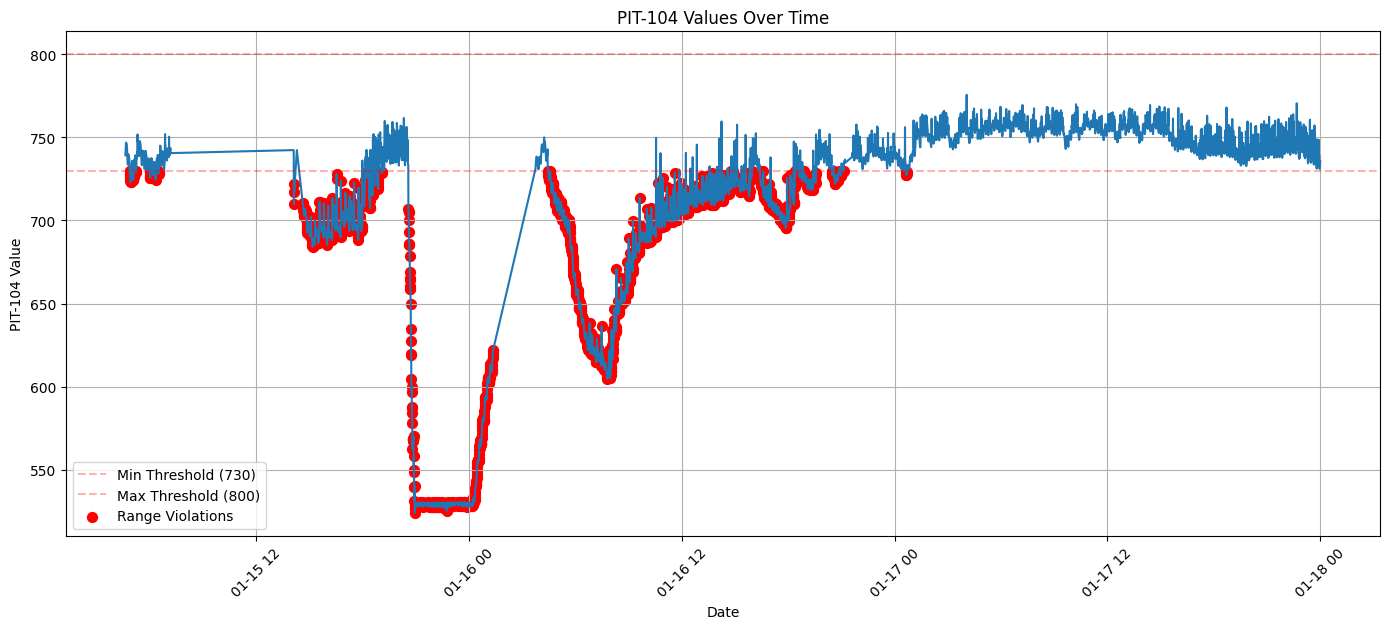

Time series decomposition failed: name 'valuen' is not defined


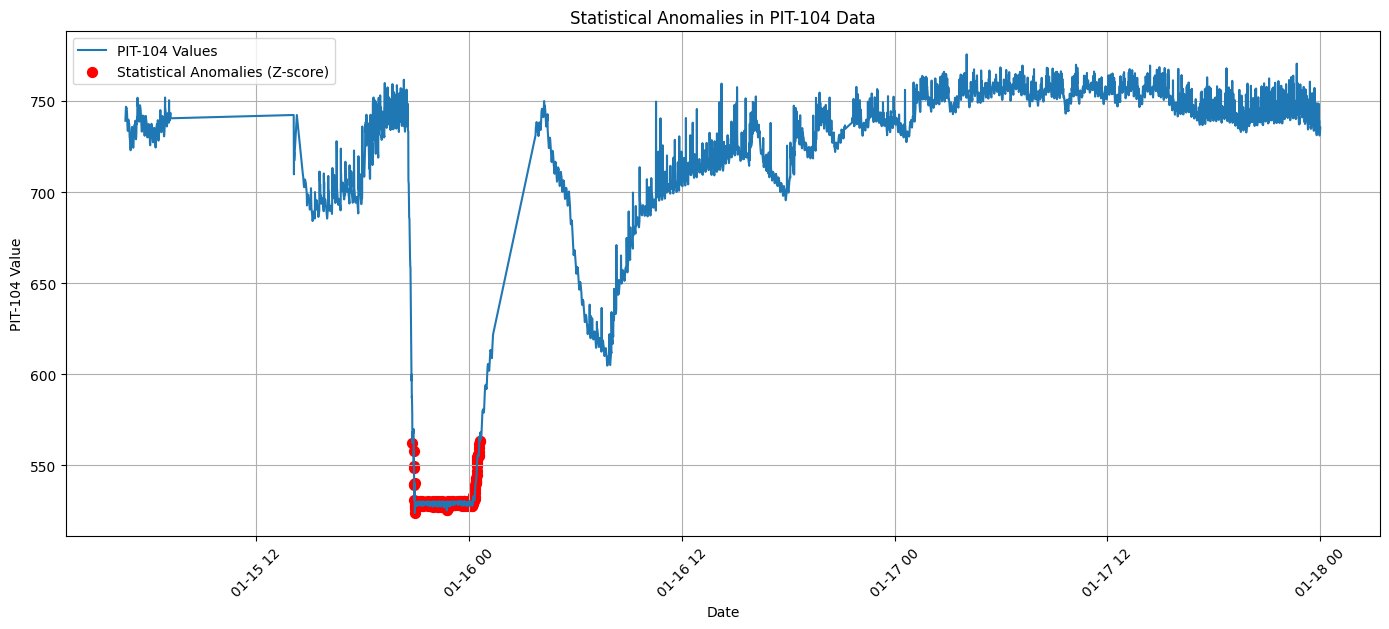

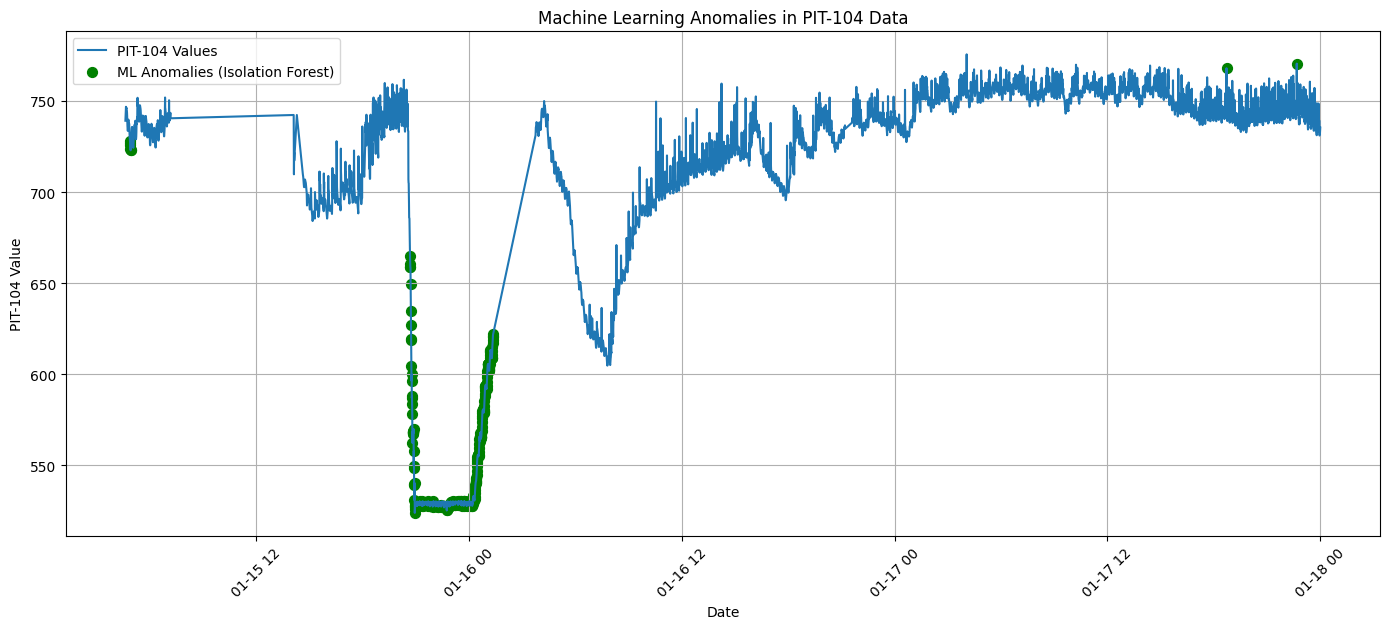

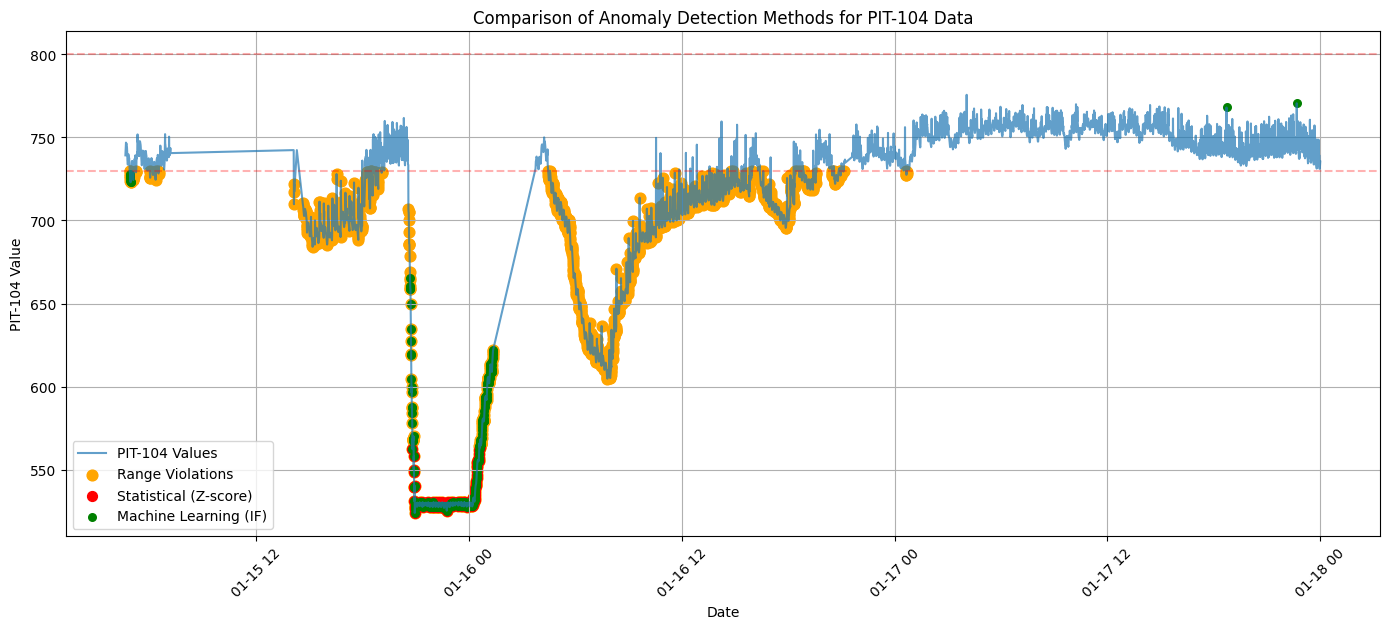


----- Anomaly Detection Summary -----
Total data points: 6847
Range violations: 2827
Statistical anomalies detected: 447
Machine learning anomalies detected: 338

----- Common Anomalies Between Methods -----
Common anomalies between Range and Statistical methods: 447
Common anomalies between Range and ML methods: 336
Common anomalies between Statistical and ML methods: 214

Anomalies detected by at least 2 methods: 569
Anomalies detected by at least 3 methods: 214

Top 10 most reliable anomalies for PIT-104:
                               indate  tagvalue  detection_count      type  \
7326 2025-01-15 20:48:52.048420+00:00    562.35                3  Pressure   
7389 2025-01-15 20:53:22.086868+00:00    549.90                3  Pressure   
7396 2025-01-15 20:53:52.094569+00:00    558.00                3  Pressure   
7403 2025-01-15 20:54:22.095504+00:00    548.54                3  Pressure   
7410 2025-01-15 20:54:52.103651+00:00    531.15                3  Pressure   
7417 2025-01-15 2

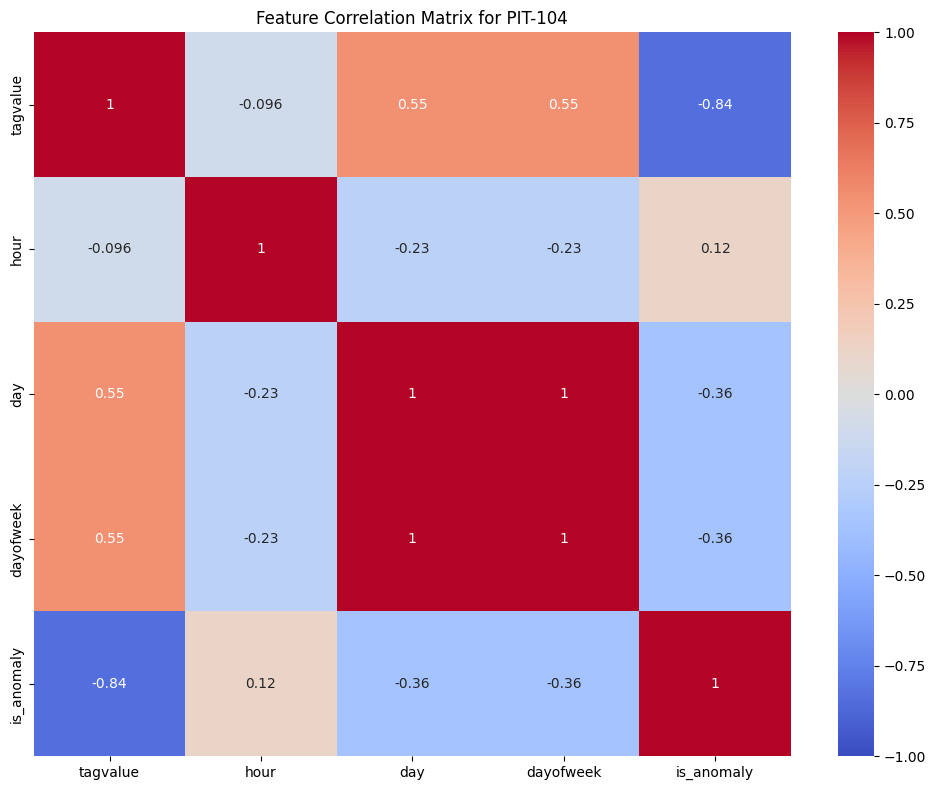

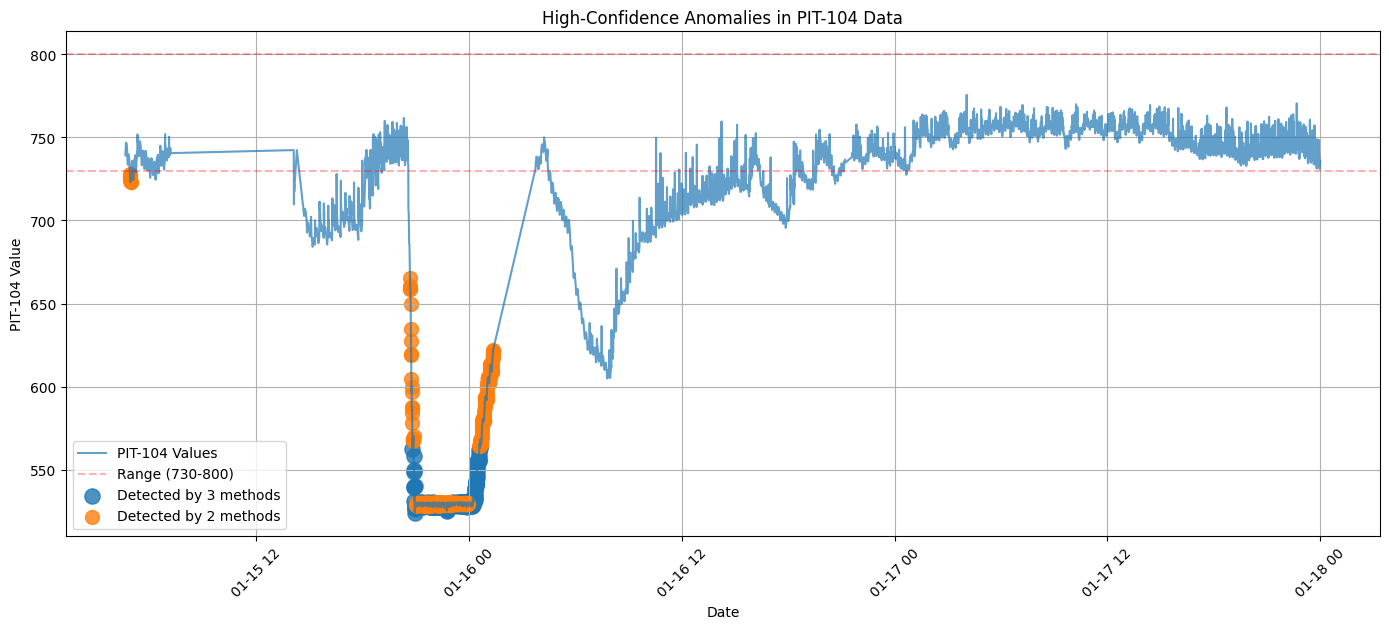


ANALYZING ST-120
Found 6840 rows of ST-120 data


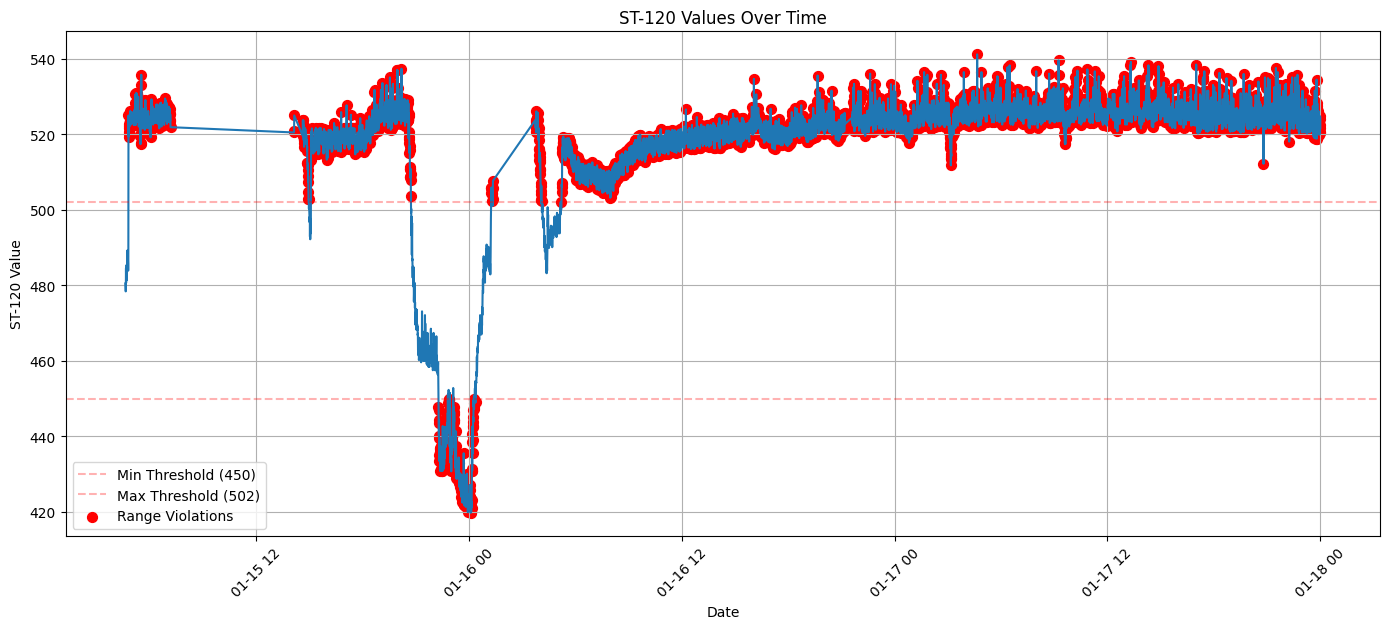

Time series decomposition failed: name 'valuen' is not defined


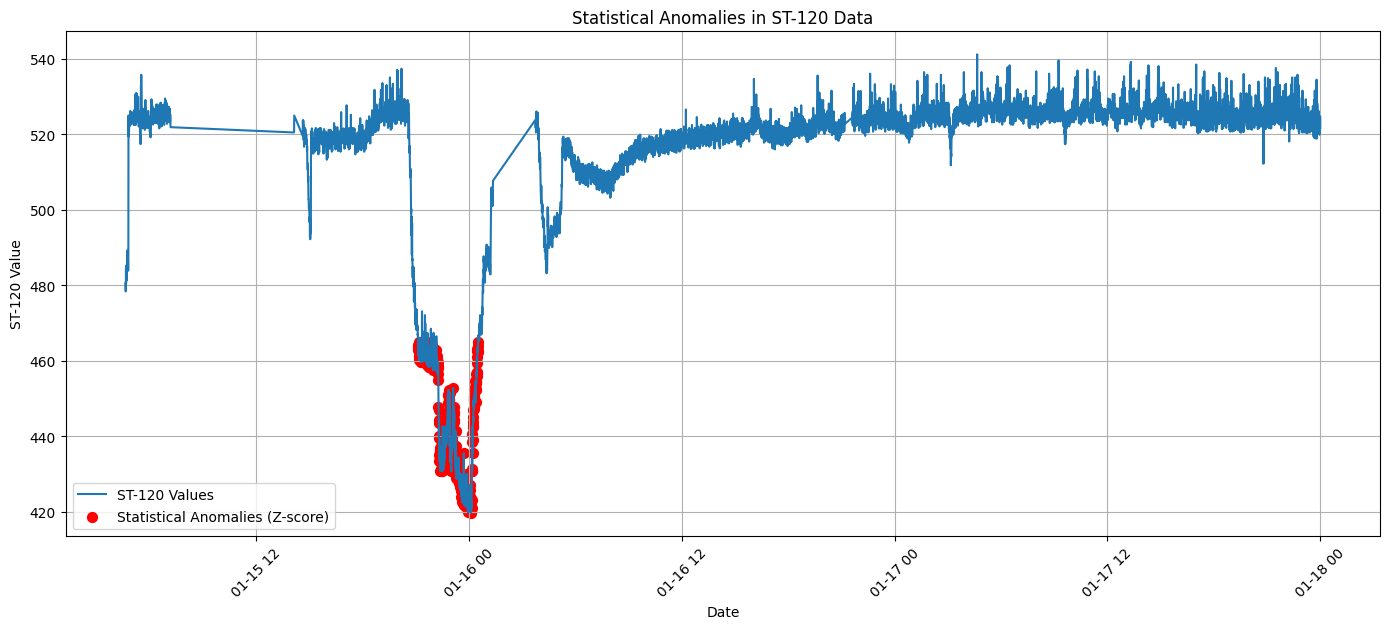

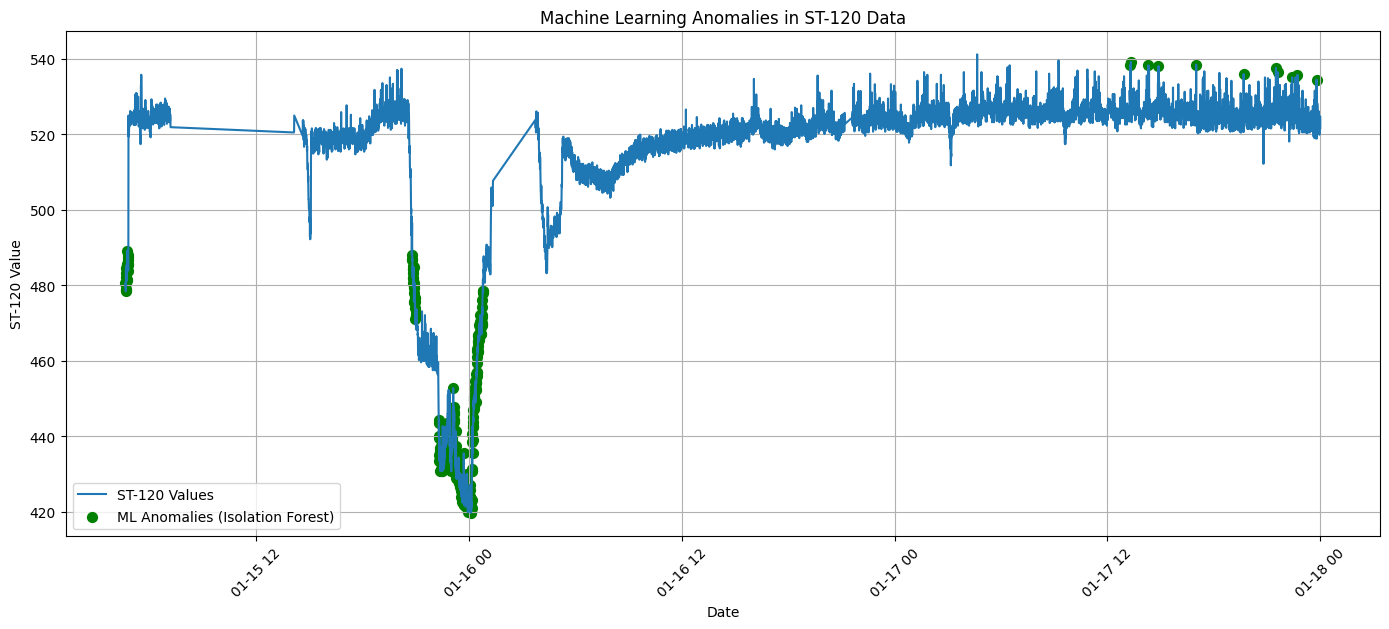

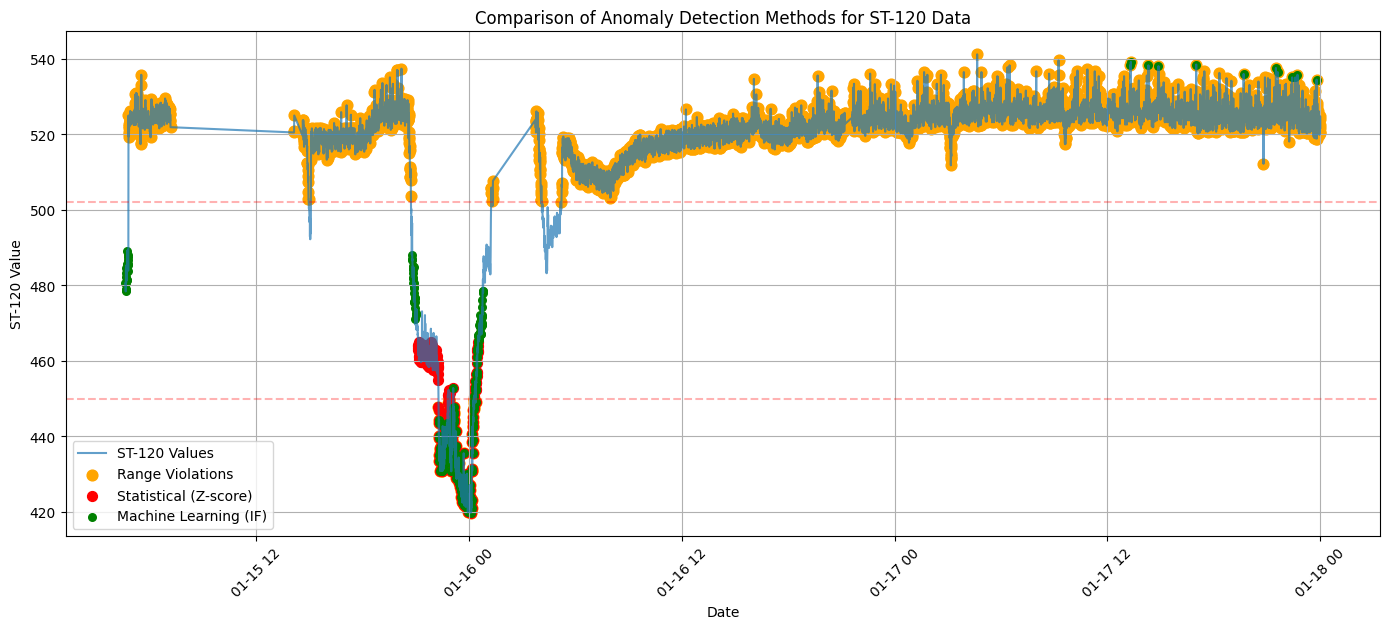


----- Anomaly Detection Summary -----
Total data points: 6840
Range violations: 6372
Statistical anomalies detected: 393
Machine learning anomalies detected: 341

----- Common Anomalies Between Methods -----
Common anomalies between Range and Statistical methods: 240
Common anomalies between Range and ML methods: 238
Common anomalies between Statistical and ML methods: 251

Anomalies detected by at least 2 methods: 277
Anomalies detected by at least 3 methods: 226

Top 10 most reliable anomalies for ST-120:
                               indate  tagvalue  detection_count  type unit  \
8575 2025-01-15 22:17:52.886253+00:00    443.39                3  Temp    f   
8582 2025-01-15 22:18:22.895957+00:00    440.00                3  Temp    f   
8589 2025-01-15 22:18:52.896821+00:00    444.20                3  Temp    f   
8596 2025-01-15 22:19:22.902939+00:00    435.00                3  Temp    f   
8603 2025-01-15 22:19:53.115019+00:00    439.50                3  Temp    f   
8610 2025-01

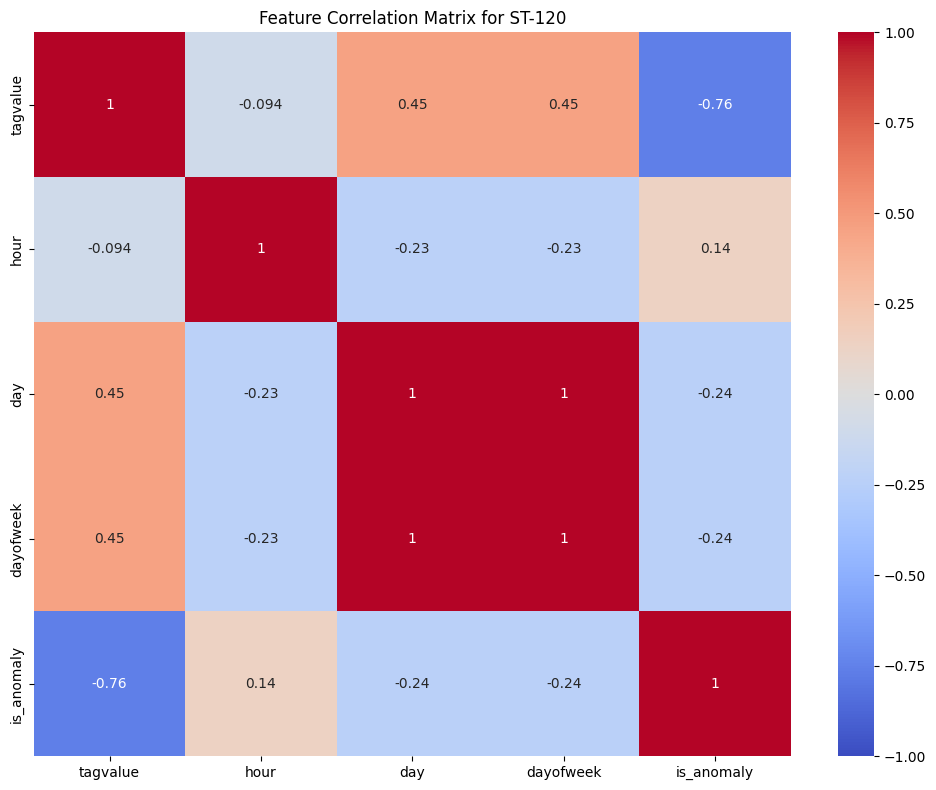

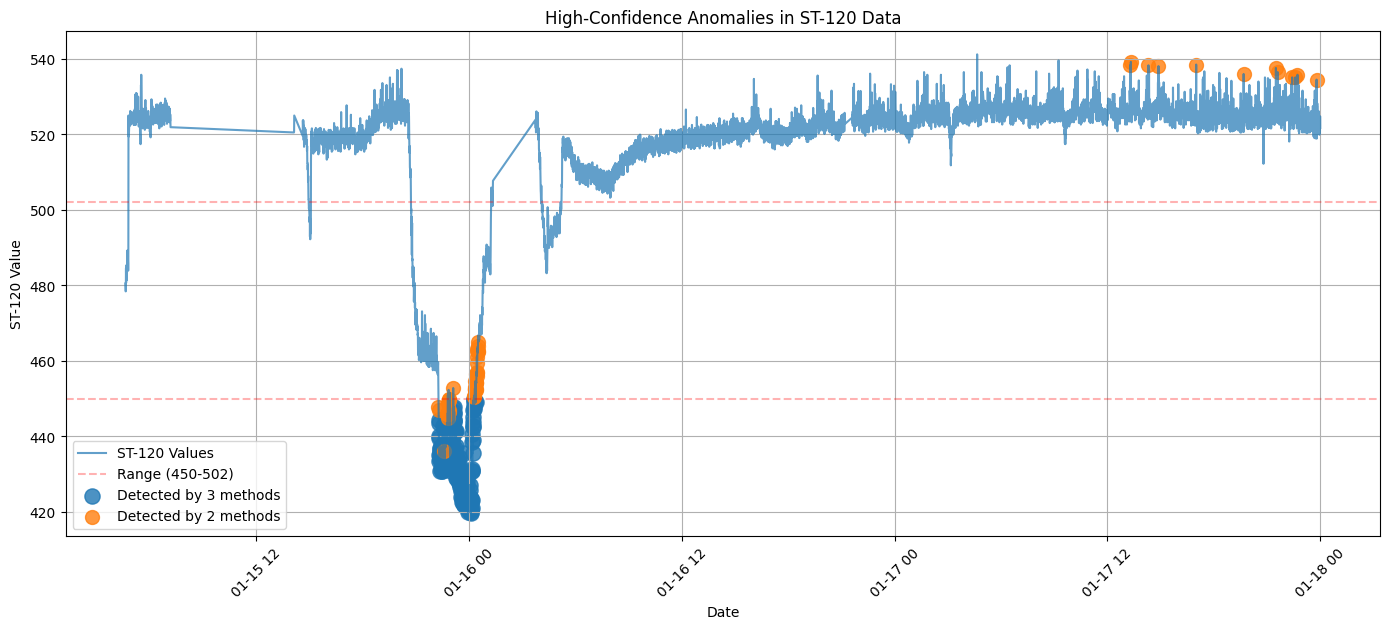


CROSS-INSTRUMENT CORRELATION ANALYSIS


In [ ]:
# Function to upload and process files
def upload_and_process_files():
    try:
        # Import Google Colab files module
        from google.colab import files

        print("Please upload your data files (.csv, .xlsx, .xls, or .xlsm)")
        uploaded = files.upload()

        if not uploaded:
            print("No files were uploaded.")
            return {}

        # Dictionary to store DataFrames
        file_dataframes = {}

        for filename, content in uploaded.items():
            print(f"Processing file: {filename}")
            if filename.endswith(('.xlsx', '.xls', '.xlsm')):
                df = pd.read_excel(io.BytesIO(content))
            elif filename.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(content))
            else:
                print(f"Unsupported file format for {filename}. Please upload .csv or Excel files.")
                continue

            print(f"Successfully loaded {filename} with {len(df)} rows and {len(df.columns)} columns")
            file_dataframes[filename] = df

        return file_dataframes

    except Exception as e:
        print(f"Error processing files: {str(e)}")
        return {}

# Function to detect anomalies for a specific instrument
def detect_anomalies(data, instrument_name, value_range, date_column='indate', value='tagvalue'):
    """
    Detect anomalies for a specific instrument based on given value range and multiple detection methods.

    Parameters:
    -----------
    data : pandas DataFrame
        The complete dataset
    instrument_name : str
        Name of the instrument to analyze (e.g., 'PIT-104', 'ST-120')
    value_range : tuple
        Expected normal range as (min, max)
    date_column : str
        Name of the column containing timestamps
    value_column : str
        Name of the column containing the measured values

    Returns:
    --------
    tuple
        (instrument_data, high_confidence_anomalies)
    """
    print(f"\n{'='*50}")
    print(f"ANALYZING {instrument_name}")
    print(f"{'='*50}")

    # Filter data for the specific instrument
    instrument_data = data[data['name'].str.contains(instrument_name, case=False, na=False)].copy()

    # Check if we found data for this instrument
    if len(instrument_data) == 0:
        print(f"No data found for {instrument_name}. Here are the unique values in the name column:")
        print(data['name'].unique())
        return None, None
    else:
        print(f"Found {len(instrument_data)} rows of {instrument_name} data")

    # Convert date column to datetime
    try:
        instrument_data[date_column] = pd.to_datetime(instrument_data[date_column])
    except:
        print(f"Warning: Could not convert {date_column} to datetime. Using as-is.")

    # Sort by date
    instrument_data = instrument_data.sort_values(date_column)

    # Create time-based features
    try:
        instrument_data['hour'] = instrument_data[date_column].dt.hour
        instrument_data['day'] = instrument_data[date_column].dt.day
        instrument_data['dayofweek'] = instrument_data[date_column].dt.dayofweek
        time_features_available = True
    except:
        print("Warning: Could not extract time features from date column")
        time_features_available = False

    # Add range-based anomaly detection (specific to the instrument's expected range)
    min_val, max_val = value_range
    instrument_data['out_of_range'] = ~instrument_data[value].between(min_val, max_val)
    range_anomalies = instrument_data[instrument_data['out_of_range']].copy()

    # Plot the time series with range violations highlighted
    plt.figure(figsize=(14, 6))
    plt.plot(instrument_data[date_column], instrument_data[value])
    plt.axhline(y=min_val, color='r', linestyle='--', alpha=0.3, label=f'Min Threshold ({min_val})')
    plt.axhline(y=max_val, color='r', linestyle='--', alpha=0.3, label=f'Max Threshold ({max_val})')

    if len(range_anomalies) > 0:
        plt.scatter(range_anomalies[date_column], range_anomalies[value],
                    color='red', s=50, label='Range Violations')

    plt.title(f'{instrument_name} Values Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{instrument_name} Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # 1. Statistical Analysis - Z-score method
    instrument_data['zscore'] = stats.zscore(instrument_data[value])
    statistical_anomalies = instrument_data[abs(instrument_data['zscore']) > 2.5].copy()

    # 2. Machine Learning - Isolation Forest
    if time_features_available:
        features = [value, 'hour', 'dayofweek']
    else:
        features = [value]

    # Handle any non-numeric data in features
    for feat in features:
        if instrument_data[feat].dtype == 'object':
            try:
                instrument_data[feat] = pd.to_numeric(instrument_data[feat])
            except:
                print(f"Warning: Could not convert {feat} to numeric. Removing from features.")
                features.remove(feat)

    if len(features) == 0:
        print("No numeric features available for Isolation Forest. Skipping ML anomaly detection.")
        ml_anomalies = pd.DataFrame()
    else:
        scaler = StandardScaler()
        instrument_scaled = scaler.fit_transform(instrument_data[features])

        # Train isolation forest
        clf = IsolationForest(contamination=0.05, random_state=42)
        instrument_data['anomaly_score'] = clf.fit_predict(instrument_scaled)
        ml_anomalies = instrument_data[instrument_data['anomaly_score'] == -1].copy()

    # 3. Time Series Decomposition
    # Need at least 2 periods for decomposition (48 data points for hourly data)
    if len(instrument_data) >= 48 and time_features_available:
        try:
            # Resample to hourly for decomposition
            instrument_hourly = instrument_data.set_index(date_column)[valuen].resample('1H').mean().fillna(method='ffill')

            # If we have at least 2 days of data
            if len(instrument_hourly) >= 48:
                # Decompose the time series
                decomposition = seasonal_decompose(instrument_hourly, model='additive', period=24)

                # Extract residuals and detect anomalies
                residuals = decomposition.resid
                residuals.dropna(inplace=True)
                residuals_mean = residuals.mean()
                residuals_std = residuals.std()
                ts_anomalies = residuals[abs(residuals - residuals_mean) > 2.5 * residuals_std]

                # Flag for time series decomposition availability
                ts_decomposition_available = True

                # Visualize the time series decomposition
                plt.figure(figsize=(14, 12))

                plt.subplot(5, 1, 1)
                plt.plot(instrument_hourly)
                plt.title(f'Original Time Series - {instrument_name} (Hourly)')
                plt.grid(True)

                plt.subplot(5, 1, 2)
                plt.plot(decomposition.trend)
                plt.title('Trend Component')
                plt.grid(True)

                plt.subplot(5, 1, 3)
                plt.plot(decomposition.seasonal)
                plt.title('Seasonal Component')
                plt.grid(True)

                plt.subplot(5, 1, 4)
                plt.plot(decomposition.resid)
                plt.title('Residual Component')
                plt.grid(True)

                plt.subplot(5, 1, 5)
                plt.plot(residuals)
                plt.scatter(ts_anomalies.index, ts_anomalies.values, color='purple', s=50)
                plt.title('Residuals with Anomalies')
                plt.grid(True)

                plt.tight_layout()
                plt.show()
            else:
                print("Not enough data for meaningful time series decomposition (need at least 48 hourly points)")
                ts_anomalies = pd.Series()
                ts_decomposition_available = False
        except Exception as e:
            print(f"Time series decomposition failed: {str(e)}")
            ts_anomalies = pd.Series()
            ts_decomposition_available = False
    else:
        print("Not enough data for time series decomposition")
        ts_anomalies = pd.Series()
        ts_decomposition_available = False

    # Visualize the statistical anomalies
    plt.figure(figsize=(14, 6))
    plt.plot(instrument_data[date_column], instrument_data[value_column], label=f'{instrument_name} Values')
    plt.scatter(statistical_anomalies[date_column], statistical_anomalies[value_column],
                color='red', s=50, label='Statistical Anomalies (Z-score)')
    plt.title(f'Statistical Anomalies in {instrument_name} Data')
    plt.xlabel('Date')
    plt.ylabel(f'{instrument_name} Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Visualize the machine learning anomalies if available
    if len(ml_anomalies) > 0:
        plt.figure(figsize=(14, 6))
        plt.plot(instrument_data[date_column], instrument_data[value_column], label=f'{instrument_name} Values')
        plt.scatter(ml_anomalies[date_column], ml_anomalies[value_column],
                    color='green', s=50, label='ML Anomalies (Isolation Forest)')
        plt.title(f'Machine Learning Anomalies in {instrument_name} Data')
        plt.xlabel('Date')
        plt.ylabel(f'{instrument_name} Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

    # Compare different anomaly detection methods
    plt.figure(figsize=(14, 6))
    plt.plot(instrument_data[date_column], instrument_data[value_column], alpha=0.7, label=f'{instrument_name} Values')

    # Plot range anomalies
    if len(range_anomalies) > 0:
        plt.scatter(range_anomalies[date_column], range_anomalies[value_column],
                    color='orange', s=60, label='Range Violations')

    # Plot statistical anomalies
    plt.scatter(statistical_anomalies[date_column], statistical_anomalies[value_column],
                color='red', s=50, label='Statistical (Z-score)')

    # Plot ML anomalies
    if len(ml_anomalies) > 0:
        plt.scatter(ml_anomalies[date_column], ml_anomalies[value_column],
                    color='green', s=30, label='Machine Learning (IF)')

    # Add time series anomalies if available
    if ts_decomposition_available and len(ts_anomalies) > 0:
        ts_anomaly_dates = ts_anomalies.index
        ts_anomaly_values = []
        for date in ts_anomaly_dates:
            # Find the closest value in the original dataset
            closest_date_idx = (instrument_data[date_column] - date).abs().idxmin()
            ts_anomaly_values.append(instrument_data.loc[closest_date_idx, value_column])

        plt.scatter(ts_anomaly_dates, ts_anomaly_values,
                    color='purple', s=80, alpha=0.6, label='Time Series (Decomposition)')

    # Add range thresholds
    plt.axhline(y=min_val, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=max_val, color='r', linestyle='--', alpha=0.3)

    plt.title(f'Comparison of Anomaly Detection Methods for {instrument_name} Data')
    plt.xlabel('Date')
    plt.ylabel(f'{instrument_name} Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Create a summary of anomalies
    print("\n----- Anomaly Detection Summary -----")
    print(f"Total data points: {len(instrument_data)}")
    print(f"Range violations: {len(range_anomalies)}")
    print(f"Statistical anomalies detected: {len(statistical_anomalies)}")
    if len(ml_anomalies) > 0:
        print(f"Machine learning anomalies detected: {len(ml_anomalies)}")
    if ts_decomposition_available:
        print(f"Time series anomalies detected: {len(ts_anomalies)}")

    # Find common anomalies across methods (more reliable detections)
    range_anomaly_dates = set(range_anomalies[date_column])
    statistical_anomaly_dates = set(statistical_anomalies[date_column])
    ml_anomaly_dates = set() if len(ml_anomalies) == 0 else set(ml_anomalies[date_column])

    # Convert time series index to datetime for comparison
    ts_anomaly_dates_set = set()
    if ts_decomposition_available and len(ts_anomalies) > 0:
        for date in ts_anomaly_dates:
            # Find the closest date in the original dataset
            closest_date_idx = (instrument_data[date_column] - date).abs().idxmin()
            ts_anomaly_dates_set.add(instrument_data.loc[closest_date_idx, date_column])

    # Find intersections
    print("\n----- Common Anomalies Between Methods -----")

    # Range + Statistical
    range_stat_common = range_anomaly_dates.intersection(statistical_anomaly_dates)
    print(f"Common anomalies between Range and Statistical methods: {len(range_stat_common)}")

    # Range + ML
    if len(ml_anomaly_dates) > 0:
        range_ml_common = range_anomaly_dates.intersection(ml_anomaly_dates)
        print(f"Common anomalies between Range and ML methods: {len(range_ml_common)}")
    else:
        range_ml_common = set()

    # Statistical + ML
    if len(ml_anomaly_dates) > 0:
        stat_ml_common = statistical_anomaly_dates.intersection(ml_anomaly_dates)
        print(f"Common anomalies between Statistical and ML methods: {len(stat_ml_common)}")
    else:
        stat_ml_common = set()

    # Range + Time Series
    if len(ts_anomaly_dates_set) > 0:
        range_ts_common = range_anomaly_dates.intersection(ts_anomaly_dates_set)
        print(f"Common anomalies between Range and Time Series methods: {len(range_ts_common)}")
    else:
        range_ts_common = set()

    # Statistical + Time Series
    if len(ts_anomaly_dates_set) > 0:
        stat_ts_common = statistical_anomaly_dates.intersection(ts_anomaly_dates_set)
        print(f"Common anomalies between Statistical and Time Series methods: {len(stat_ts_common)}")
    else:
        stat_ts_common = set()

    # ML + Time Series
    if len(ml_anomaly_dates) > 0 and len(ts_anomaly_dates_set) > 0:
        ml_ts_common = ml_anomaly_dates.intersection(ts_anomaly_dates_set)
        print(f"Common anomalies between ML and Time Series methods: {len(ml_ts_common)}")
    else:
        ml_ts_common = set()

    # Anomalies detected by at least 2 methods
    all_two_method_common = range_stat_common.union(range_ml_common).union(range_ts_common).union(
                             stat_ml_common).union(stat_ts_common).union(ml_ts_common)
    print(f"\nAnomalies detected by at least 2 methods: {len(all_two_method_common)}")

    # Anomalies detected by at least 3 methods
    all_three_method_common = set()
    methods_available = 1 + 1 + (1 if len(ml_anomaly_dates) > 0 else 0) + (1 if len(ts_anomaly_dates_set) > 0 else 0)

    if methods_available >= 3:
        three_method_combinations = []

        if len(ml_anomaly_dates) > 0:
            three_method_combinations.append(range_anomaly_dates.intersection(statistical_anomaly_dates).intersection(ml_anomaly_dates))

        if len(ts_anomaly_dates_set) > 0:
            three_method_combinations.append(range_anomaly_dates.intersection(statistical_anomaly_dates).intersection(ts_anomaly_dates_set))

        if len(ml_anomaly_dates) > 0 and len(ts_anomaly_dates_set) > 0:
            three_method_combinations.append(range_anomaly_dates.intersection(ml_anomaly_dates).intersection(ts_anomaly_dates_set))
            three_method_combinations.append(statistical_anomaly_dates.intersection(ml_anomaly_dates).intersection(ts_anomaly_dates_set))

        for combo in three_method_combinations:
            all_three_method_common = all_three_method_common.union(combo)

        print(f"Anomalies detected by at least 3 methods: {len(all_three_method_common)}")

    # Anomalies detected by all 4 methods
    all_four_method_common = set()
    if methods_available == 4:
        all_four_method_common = range_anomaly_dates.intersection(statistical_anomaly_dates).intersection(
                                 ml_anomaly_dates).intersection(ts_anomaly_dates_set)
        print(f"Anomalies detected by all 4 methods: {len(all_four_method_common)}")

    # Create a dataframe with high-confidence anomalies (detected by at least 2 methods)
    high_confidence_dates = list(all_two_method_common)
    high_confidence_anomalies = instrument_data[instrument_data[date_column].isin(high_confidence_dates)].copy()

    # If we don't have any high-confidence anomalies, use range violations
    if len(high_confidence_anomalies) == 0:
        print(f"\nNo high-confidence anomalies detected. Using range violations.")
        high_confidence_anomalies = range_anomalies.copy()
        high_confidence_anomalies['detection_count'] = 1
    else:
        # Add a column indicating how many methods detected this anomaly
        high_confidence_anomalies['detection_count'] = 0
        for idx, row in high_confidence_anomalies.iterrows():
            count = 0
            if row[date_column] in range_anomaly_dates:
                count += 1
            if row[date_column] in statistical_anomaly_dates:
                count += 1
            if row[date_column] in ml_anomaly_dates:
                count += 1
            if row[date_column] in ts_anomaly_dates_set:
                count += 1
            high_confidence_anomalies.loc[idx, 'detection_count'] = count

    # Sort by detection count (most reliable first)
    high_confidence_anomalies = high_confidence_anomalies.sort_values(by=['detection_count', date_column], ascending=[False, True])

    # Display the top anomalies (or all if less than 10)
    num_to_display = min(10, len(high_confidence_anomalies))
    print(f"\nTop {num_to_display} most reliable anomalies for {instrument_name}:")
    display_columns = [date_column, value_column, 'detection_count']

    # Add additional columns if they exist
    additional_cols = ['type', 'unit', 'id', 'category', 'description', 'tag']
    for col in additional_cols:
        if col in high_confidence_anomalies.columns:
            display_columns.append(col)

    top_anomalies = high_confidence_anomalies.head(num_to_display)
    print(top_anomalies[display_columns])

    # Feature correlation analysis if we have time features
    if time_features_available:
        corr_features = [value_column, 'hour', 'day', 'dayofweek']
        corr_data = instrument_data[corr_features].copy()
        corr_data['is_anomaly'] = instrument_data[date_column].isin(high_confidence_dates).astype(int)

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Feature Correlation Matrix for {instrument_name}')
        plt.tight_layout()
        plt.show()

    # Final visualization showing high-confidence anomalies
    plt.figure(figsize=(14, 6))
    plt.plot(instrument_data[date_column], instrument_data[value_column], alpha=0.7, label=f'{instrument_name} Values')

    # Add range thresholds
    plt.axhline(y=min_val, color='r', linestyle='--', alpha=0.3, label=f'Range ({min_val}-{max_val})')
    plt.axhline(y=max_val, color='r', linestyle='--', alpha=0.3)

    # Color code by number of methods that detected the anomaly
    if 'detection_count' in high_confidence_anomalies.columns:
        for count in sorted(high_confidence_anomalies['detection_count'].unique(), reverse=True):
            subset = high_confidence_anomalies[high_confidence_anomalies['detection_count'] == count]
            if len(subset) > 0:
                plt.scatter(subset[date_column], subset[value_column],
                           s=60+20*count, alpha=0.8,
                           label=f'Detected by {count} method{"s" if count > 1 else ""}')
    else:
        plt.scatter(high_confidence_anomalies[date_column], high_confidence_anomalies[value_column],
                   s=80, alpha=0.8, label='Anomalies')

    plt.title(f'High-Confidence Anomalies in {instrument_name} Data')
    plt.xlabel('Date')
    plt.ylabel(f'{instrument_name} Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # Return the results for potential further analysis
    return instrument_data, high_confidence_anomalies

# Main execution function
def main():
    # Upload and process files
    file_dataframes = upload_and_process_files()

    # If no files were uploaded or found, provide an example of how to load data
    if not file_dataframes:
        print("No data files found. Creating synthetic dataset for demonstration...")
        np.random.seed(42)

        # Create date range
        dates = pd.date_range(start='2023-01-01', periods=500, freq='H')

        # Create dataframe
        data_list = []

        # PIT-104 data (normal range: 730-800)
        pit_values = np.random.normal(loc=765, scale=10, size=len(dates))
        # Add some anomalies
        anomaly_indices = np.random.choice(range(len(dates)), size=20, replace=False)
        for idx in anomaly_indices:
            if np.random.random() < 0.5:
                pit_values[idx] = np.random.uniform(700, 729)  # Below range
            else:
                pit_values[idx] = np.random.uniform(801, 830)  # Above range

        for i, date in enumerate(dates):
            data_list.append({
                'indate': date,
                'name': 'PIT-104',
                'type': 'Pressure',
                'unit': 'PSI',
                'id': 'P1001',
                'category': 'Critical',
                'description': 'Pressure Indicator Transmitter',
                'tag': 'Vessel-A',
                'value': pit_values[i]
            })

        # ST-120 data (normal range: 450-502)
        st_values = np.random.normal(loc=476, scale=8, size=len(dates))
        # Add some anomalies
        anomaly_indices = np.random.choice(range(len(dates)), size=15, replace=False)
        for idx in anomaly_indices:
            if np.random.random() < 0.5:
                st_values[idx] = np.random.uniform(430, 449)  # Below range
            else:
                st_values[idx] = np.random.uniform(503, 520)  # Above range

        for i, date in enumerate(dates):
            data_list.append({
                'indate': date,
                'name': 'ST-120',
                'type': 'Temperature',
                'unit': '°F',
                'id': 'T2001',
                'category': 'Critical',
                'description': 'Steam Temperature',
                'tag': 'Vessel-B',
                'value': st_values[i]
            })

        # Create dataframe
        synthetic_data = pd.DataFrame(data_list)

        # Use the synthetic data for analysis
        data = synthetic_data
    else:
        # Use the first dataframe from uploaded files (replace with more specific selection if needed)
        data = next(iter(file_dataframes.values()))

    # Define the normal ranges for each instrument
    instrument_ranges = {
        'PIT-104': (730, 800),
        'ST-120': (450, 502)
    }

    # Analyze each instrument
    results = {}
    for instrument_name, value_range in instrument_ranges.items():
        instrument_data, anomalies = detect_anomalies(data, instrument_name, value_range)
        if instrument_data is not None:
            results[instrument_name] = {
                'data': instrument_data,
                'anomalies': anomalies
            }

    # Cross-instrument analysis
    if len(results) > 1:
        print("\n===============================================")
        print("CROSS-INSTRUMENT CORRELATION ANALYSIS")
        print("===============================================")

        # Merge anomaly timestamps to check for coincident anomalies
        all_anomaly_dates = {}
        for instrument, result in results.items():
            if result['anomalies'] is not None and len(result['anomalies']) > 0:
                all_anomaly_dates[instrument] = set(result['anomalies']['indate'])

        # Find coincident anomalies
        instruments = list(all_anomaly_dates.keys())
        if len(instruments) >= 2:
            for i in range(len(instruments)):
                for j in range(i+1, len(instruments)):
                    instr1, instr2 = instruments[i], instruments[j]
                    common_dates = all_anomaly_dates[instr1].intersection(all_anomaly_dates[instr2])

                    if common_dates:
                        print(f"\nFound {len(common_dates)} coincident anomalies between {instr1} and {instr2}")
                        print("Times:")
                        for date in sorted(common_dates):
                            print(f"  - {date}")

                        # Plot coincident anomalies
                        plt.figure(figsize=(14, 8))

                        # Create two y-axes
                        ax1 = plt.gca()
                        ax2 = ax1.twinx()

                        # Plot time series for first instrument
                        instr1_data = results[instr1]['data']
                        instr1_anomalies = results[instr1]['anomalies']
                        ax1.plot(instr1_data['indate'], instr1_data['value'], 'b-', alpha=0.7, label=instr1)
                        ax1.set_ylabel(f'{instr1} Value', color='b')
                        ax1.tick_params(axis='y', labelcolor='b')

                        # Plot time series for second instrument
                        instr2_data = results[instr2]['data']
                        instr2_anomalies = results[instr2]['anomalies']
                        ax2.plot(instr2_data['indate'], instr2_data['value'], 'g-', alpha=0.7, label=instr2)
                        ax2.set_ylabel(f'{instr2} Value', color='g')
                        ax2.tick_params(axis='y', labelcolor='g')

                        # Highlight common anomaly points
                        for date in common_dates:
                            # Find corresponding data points
                            instr1_point = instr1_data[instr1_data['indate'] == date]
                            instr2_point = instr2_data[instr2_data['indate'] == date]

                            if not instr1_point.empty and not instr2_point.empty:
                                ax1.scatter(date, instr1_point['value'].values[0], color='r', s=100, zorder=5)
                                ax2.scatter(date, instr2_point['value'].values[0], color='r', s=100, zorder=5)

                        plt.title(f'Coincident Anomalies between {instr1} and {instr2}')
                        plt.xlabel('Date')

                        # Create legend entries for both y-axes
                        lines1, labels1 = ax1.get_legend_handles_labels()
                        lines2, labels2 = ax2.get_legend_handles_labels()
                        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

                        plt.grid(True)
                        plt.tight_layout()
                        plt.xticks(rotation=45)
                        plt.show()

# Run the main function
if __name__ == "__main__":
    main()